In [1]:
# cell 0
import time

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm # рисовалка qq-plot.

# инструмент для создания и обучения модели.
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split # специальный инструмент для разбивки.
from sklearn import metrics # инструменты для оценки точности модели.

from sklearn import preprocessing

# Библиотеки для отбора признаков.
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anovav

# Библиотека кодирования.
import category_encoders as ce

# Progress bar.
from colorama import Fore, Back, Style # Чтоб аутпут был цветастый.
from tqdm.notebook import tqdm
tqdm.pandas(desc="my bar!")

import re

# I’ll leave here the display of the entire row, a useful thing when you are poking around in the data manually.
pd.set_option('display.width', 80) #80
pd.set_option('display.max_colwidth', 50) #50 displaying the entire text in a cell
pd.set_option('display.max_rows', 60) #60 - output length (down)
pd.set_option('display.float_format', None) #None so that float is displayed normally ('{:.6f}'.format) pd.set_option('display.float_format', '{:.6f}'.format)

# Я забыл, но это параметры отображения графиков.
%matplotlib inline
matplotlib.style.use('fast')

# И здесь же, с вашего позволения, обозначу ссылки на файлы с гугл диска, т.к. на гитхаб не помещается больше 50 мб.
# Если запускать ячейку с загрузкой несколько раз подряд может возникнуть ошибка HTTP Error 500 и придётся перезагружать ipynb файл.
hotels_test_link = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1wQNBWtVSxkHhjpo_5Wn8EcSHMx2CzMFX'
vader_sent_link = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1uzhIwD8hablg43PFbEbrAXUVEY1XxHHy'
vader_sent_test_data_link = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1kRe4-zc2jZiCzUvx8yLxkMLipKDVEtUc'
roberta_neg_vs_pos_link = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1HmpKb2s3f7YeSL8Faza-X4YZwvTAVA3J'
roberta_neg_vs_pos_test_data_link = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1t-2Jx4HUOibwdBdloQtXEJ-92tTSf2t2'

# Здесь происходит подгрузка трейн таблицы. Т.к. в гугле видать закрыли лазейку.
# Раньше работало confirm=no_antivirus, а щас нет. Потому gdown.
import gdown
gdown.download('https://drive.google.com/uc?export=download&id=13lPw9ROLXawDwBNnT5y7LRBJkmpV8Uun', 'hotels_train.csv', quiet=False)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Downloading...
From (original): https://drive.google.com/uc?export=download&id=13lPw9ROLXawDwBNnT5y7LRBJkmpV8Uun
From (redirected): https://drive.google.com/uc?export=download&id=13lPw9ROLXawDwBNnT5y7LRBJkmpV8Uun&confirm=t&uuid=73738d3d-ae89-43d3-8ff9-ebd338ce1bd0
To: /Users/Kristina/My_code_career/GIT_LIFE/PROJECTS.EDU/3.Project-3:Booking_reviewer_score_prediction/hotels_train.csv
100%|██████████| 178M/178M [00:16<00:00, 10.7MB/s] 


<center><font face='sans-serif' color=0a3a7a size=40>Booking</font><font face='sans-serif' color=00aef0 size=40>.com</font></center>
<br></br>
<div style="border: 3px outset green; border-radius: 15px 50px 30px 5px; background: #b0ea9e; color: black; text-align:left; vertical-align: middle; padding:15px 20px 3px; width: auto;">

<font color=#134a0b><u>КАКОЙ КЕЙС РЕШАЕМ?</u></font>

Представим, что работаем дата-сайентистом в компании <font face='sans-serif' color=0a3a7a>Booking</font><font face='sans-serif' color=00aef0>.com</font>. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

<div style="background: #228b22; border-radius: 15px / 50px; box-shadow: 10px 10px 5px darkgray; color: #fff; border-left: 8px solid darkgreen; text-align:left; vertical-align: middle; padding:15px 20px 3px; width: auto;">

<span style="display: inline-block; float: right; text-align: center; line-height: 30px; font-size: 16px; color: #fff; width: 30px; height: 30px; border: 2px solid #fff; border-radius: 50%; margin: -5px 20px 20px;">0k</span>Задача - создать такую модель.
</div>
<br>
</div>
<br></br>
<u>Описание столбцов</u>:

1-я группа признаков:

* `hotel_address` — адрес отеля;
* `hotel_name` — название отеля;
* `reviewer_nationality` — страна рецензента;
* `lat` — географическая широта отеля;
* `lng` — географическая долгота отеля;

<p></p>
2-я группа признаков:

* `review_date` — дата, когда рецензент разместил соответствующий отзыв;
* `days_since_review` — количество дней между датой проверки и датой очистки;

<p></p>
3-я группа признаков:

* `negative_review` — отрицательный отзыв, который рецензент дал отелю;
* `positive_review` — положительный отзыв, который рецензент дал отелю;
* `tags` — теги, которые рецензент дал отелю;

<p></p>
4-я группа признаков:

* `total_number_of_reviews_reviewer_has_given` — количество отзывов, которые рецензенты дали в прошлом;
* `total_number_of_reviews` — общее количество действительных отзывов об отеле;
* `additional_number_of_scoring` — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки;
* `review_total_negative_word_counts` — общее количество слов в отрицательном отзыве;
* `review_total_positive_word_counts` — общее количество слов в положительном отзыве;

<p></p>
Признаки, содержащие оценку:

* `average_score` — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* `reviewer_score` — оценка, которую рецензент поставил отелю на основе своего опыта;

<h2 id='contents'>Оглавляшка:</h2>

1. [Блок функций](#funcblock)
2. [Интро](#intro)
3. [Первый блок исследований](#firstresearchblock)
    * [Разбор первой группы признаков (name, address, nationality, lat, lng)](#fstcolgroup)
    * [Разбор второй группы признаков (date, d_s_r)](#scndcolgroup)
    * [Разбор третьей группы признаков (tags*)](#thrdcolgroup)
    * [Выбросы первого блока](#outliersfirstblock)
    * [Разбор четвёртой группы признаков (t_n_r_r_h_g, t_n_r, a_n_s, r_t_n_w_c, r_t_p_w_c)](#fourthcolsgroup)
    * [Отбор первого блока](#fblselection)
    * [Тренировка модели](#firblotraining)
4. [Второй блок исследований.](#secondresearchblock)
    * [Обработка текстовых столбцов с отзывами (positive_review, negative_review)](#textfarming)
    * [Отбор второго блока](#sndblselection)
    * [Тренировка модели](#sndbltraining)
5. [Итоговая модель.](#modellocation)


## Блок функций <a id='funcblock'></a>

In [2]:
# Function block. Usefull for me.
# My info.
def my_info(df, catmaxnum=None):
    """Info function to show basic df indicators

    Args:
        df (pd.Dataframe): any df.
        catmaxnum (int): the minimum threshold(rus: порог) after which a column will be considered a category. Defaults to None.

    Returns:
        _type_: pd.Dataframe
    """
    df_copy = df.copy() # it needs here.
    
    # Loop and condition for moment, when there are unhashable types in our column. (list, dict, set)
    for i in df_copy.columns:
        if any(isinstance(cell, (list, set, dict)) for cell in df_copy[i]):
            df_copy[i] = df_copy[i].astype(str)
                
    func_df = pd.DataFrame({
        
        'column': df_copy.columns,
        'num of unique vals': df_copy.nunique(),
        'type': [str(df_copy.dtypes[i]) for i in df_copy.columns],
        'mode': [df_copy[i].mode()[0] for i in df_copy.columns],
        'number of entries': len(df_copy),
        'NaN vals': df_copy.isna().sum(),
        'number of dublics': df_copy.duplicated().sum(),
        'describe': [{'min': df_copy[i].min(), 'max': df_copy[i].max(), 'mean': round(df_copy[i].mean()), 'std': round(df_copy[i].std())} if np.issubdtype(df_copy[i].dtype, np.number) else 'type obj' for i in df_copy.columns]
        
    }).sort_values(by='num of unique vals').reset_index(drop=True)
    
    if catmaxnum:
        func_df.insert(3, 'classification', ['category' if i < catmaxnum else 'numeric' for i in func_df['num of unique vals']])
        
    return func_df
# --------------------------------------------------------------------------------------------------------------------------------------

# Tukie outliers finder function.
def outliers_iqr_mode_log(data, feature=None, log_scale=False, left=1.5, right=1.5):
    
    func_data = data.copy()
    
    if isinstance(func_data, pd.DataFrame):    
        if log_scale: # if we want to logarithm a feature.
            if any(func_data[feature] == 0):
                x = np.log(func_data[feature] + 1)
            else:
                x = np.log(func_data[feature])
        else:
            x = func_data[feature]
    else:
        x = func_data # if data == array or series
        
    quantile_25, quantile_75 = x.quantile(0.25), x.quantile(0.75)
    iqr = quantile_75 - quantile_25
    
    lower_bound = quantile_25 - iqr * left
    upper_bound = quantile_75 + iqr * right
    
    outliers = func_data[(x < lower_bound) | (x > upper_bound)]
    cleaned = func_data[(x >= lower_bound) & (x <= upper_bound)]
    
    return outliers, cleaned.reset_index(drop=True)
# --------------------------------------------------------------------------------------------------------------------------------------

def hist_box_qq(arg, full_iqr=False):
    """Function of drawing histogram, box and cuckoo in one bottle.

    full_iqr... It's shorter.. I wrote a function for the lognormal distribution, i.e. there are no outliers on the left.
    But then I thought about it and decided to add it, because then I still log the feature.
    And in general, if the array is usually distributed.
    In a word: full_iqr is Boolean. By default, False. I.e., only the right borders are drawn.
    
    The input is a Series or array.

    Args:
        arg (Series/np.array): any numeric series or array.
        full_iqr (bool, optional): choose, u wanna show only right outliers borders or both. Defaults to False.

    Returns:
        plt
    """
    func_arg = arg.copy()
    # replace inf.
    func_arg = func_arg.replace([np.inf, -np.inf], np.nan)
    # If there is a nan, I drop it. Because it does not draw if there is a nan.
    func_arg = pd.Series(func_arg).dropna()
    
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=[18, 5])
    
    # The histogram. And the settings for the histogram lines. Legend = label in each line.
    # Red is the median, green is the tukey, and blue is 3 sigma.
    sns.histplot(func_arg, kde=True, bins=50, ax=ax[0])
    
    ax[0].get_lines()[0].set_color('black')
    ax[0].axvline(func_arg.median(), color='red', linestyle='--', linewidth='1.8', label='median')
    ax[0].axvline(func_arg.quantile(0.75) + ((func_arg.quantile(0.75) - func_arg.quantile(0.25)) * 1.5), color='g', ls='--', lw=2, label='1.5 IQR Tukie')
    ax[0].axvline(func_arg.mean() + 3 * func_arg.std(), color='b', ls='--', lw=2, label='3 IQR z-score')
    ax[0].legend()
    ax[0].set_xlabel(f'Feauture {func_arg.name}')
    
    # Box. And the settings for it.
    sns.boxplot(func_arg, ax=ax[1], orient='h', medianprops={'color': 'red', 'linestyle': '--'})

    ax[1].axvline(func_arg.quantile(0.75) + ((func_arg.quantile(0.75) - func_arg.quantile(0.25)) * 1.5), color='g', ls='--', lw=2, label='1.5 IQR Tukie')
    ax[1].axvline(func_arg.mean() + 3 * func_arg.std(), color='b', ls='--', lw=2, label='3 IQR z-score')
    ax[1].legend()    
    ax[1].set_xlabel(f'Feauture {func_arg.name}')
    
    if full_iqr: # Left emission catch lines are added.
        ax[0].axvline(func_arg.quantile(0.25) - ((func_arg.quantile(0.75) - func_arg.quantile(0.25)) * 1.5), color='g', ls='--', lw=2)
        ax[0].axvline(func_arg.mean() - 3 * func_arg.std(), color='b', ls='--', lw=2)
        ax[1].axvline(func_arg.quantile(0.25) - ((func_arg.quantile(0.75) - func_arg.quantile(0.25)) * 1.5), color='g', ls='--', lw=2)
        ax[1].axvline(func_arg.mean() - 3 * func_arg.std(), color='b', ls='--', lw=2)
    
    # This line builds a Q-Q graph.
    qq = sm.ProbPlot(func_arg, fit=True).qqplot(marker='*', markerfacecolor='b', markeredgecolor='b', alpha=0.3, ax=ax[2])
    # Line, also with the ability to influence color. fmt parameter.
    sm.qqline(qq.axes[2], line='45', fmt='r', linestyle='--')
    
    # The general title.
    plt.suptitle(f'Distribution of the feature: {func_arg.name}').set_fontsize(20)
    
    return plt
# --------------------------------------------------------------------------------------------------------------------------------------

def my_corr(df, method='spearman', corrneg=0, corrpos=0, figsize=(10, 5), xtickrot=90, show_high_corr_cols_names=False):
    """
    The function of drawing a correlation graph, but not an ordinary one, but one in which the lower part is the entire one,
    and the upper part contains only those correlation values that are greater and less than some number we have specified.

    Args:
        df (pd.Dataframe): any df.
        method (str): method u like. default spearman.
        corrneg (float): negative threshold for display. (for negative correlation value)
        corrpos (float): positive threshold. (for a positive value) both default to 0. At 0, the full standard correlation matrix will be displayed.
        figsize (tuple): u know what it is.)
        xtickrot(int): rotate x axis labels. default 90
        show_high_corr_cols_names(bool): if we wanna watch names of high corr cols. default False

    Returns:
        _type_: plt or df
    """
    corr_df = df.corr(numeric_only=True, method=method)
    
    # We find indices where the correlation value is greater and less than a certain number.
    high_corr_pairs = ((corr_df >= corrpos) & (corr_df <= 1)) | (corr_df <= corrneg)
    
    # We receive only those pairs of features where the condition is met. The rest are NaN.
    high_corr_features = corr_df[high_corr_pairs]
    
    # if we wanna watch high corr pairs in the form of a df. Without picture. I decided 2 split it up.
    if show_high_corr_cols_names:
        # stack hight corr feature.
        shccn = high_corr_features.stack().to_frame().reset_index().rename(columns={0: 'corr'})
        # sort'em.
        shccn[['level_0', 'level_1']] = np.sort(shccn[['level_0', 'level_1']], axis=1)
        # keep only 1 pair of high corr cols names.
        shccn = shccn.groupby(['level_0', 'level_1']).first().reset_index()
        # removing the diagonal.
        shccn = shccn.query('level_0 != level_1')
        # return with resetting index.
        return shccn.sort_values(by='corr', ascending=False).reset_index(drop=True)
    
    # if we wanna see the pic.
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
        plt.suptitle(f'Correlation of incoming dataframe features.')
        
        # 2 masks, one triu (tri upper), the second tril (tri lower).
        mask_for_logging_df = np.triu(np.ones_like(corr_df, dtype=bool))
        mask_for_logging_df_2 = np.tril(np.ones_like(high_corr_features, dtype=bool))
        
        # 2 graphics. I didn’t figure out how to make such a picture using 1 chart. That's why cbar=False helps.
        sns.heatmap(corr_df, annot=True, cmap='coolwarm', mask=mask_for_logging_df, vmax=1, vmin=-1, linewidths=0.1, fmt='.2f') # <--- lower part
        
        # if condition == 1 high_corr_features contains only nan, so we dont need upper part. 
        # or.. high_corr_features has no nan, i.e. corrpos and corrneg == 0, so we draw all corr matrix.
        if (len(high_corr_features.isna().sum().value_counts()) != 1) | ((corrpos == 0) & (corrneg == 0)):
            sns.heatmap(high_corr_features, annot=True, cmap='coolwarm', mask=mask_for_logging_df_2, cbar=False, vmax=1, vmin=-1, linewidths=0.1, fmt='.2f') # <--- upper part
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=xtickrot) # rotation of xticks
    
        plt.plot([0, len(df.columns)], [0, len(df.columns)], color='black', linewidth=2); # It's just a line. I don't know why. But i like it.
        
        return plt

# --------------------------------------------------------------------------------------------------------------------------------------

def label_group_bar_table(ax, df):
    """label_group_bar_table 

    Чумовейшие три функции, которые рисуют мультииндекс разметку по оси Х!!!
    На вход подаётся ax и датафрейм вида: 
     1. главный индекс; 
     2. второстепенный индекс или группа индексов, по иерархии от старшего к младшему; 
     3. последним идёт индекс, который является оттенком (hue).
     Вид группировки: .groupby(['1_st_order_idx', '2_nd_order_idx', ..., 'hue_idx'])['nums_column'].mean().unstack()
     P.S. для работы нужен groupby из itertools
     P.S.2 Сие ваяние не моё, потому хз, что там происходит и я не распишу каждую строчку, но результат меня устраивает.)

    Args:
        ax (_type_): ax with ur plot.
        df (_type_): ur df which u wanna plot.
    """
    from itertools import groupby # для рисования мультииндекс меток по оси х (и не только, но здесь - только).
    
    def add_line(ax, xpos, ypos):
        line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                          transform=ax.transAxes, color='gray')
        line.set_clip_on(False)
        ax.add_line(line)
    
    def label_len(my_index,level):
        labels = my_index.get_level_values(level)
        return [(k, sum(np.fromiter((1 for i in g), dtype=int))) for k, g in groupby(labels)]
    
    
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index, level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale ,ypos)
        ypos -= .1
# --------------------------------------------------------------------------------------------------------------------------------------

def f_classif_chi_tester(series, targ_col):
    """f_classif_chi_tester _summary_

    Функция.. проводит тестирование f_classifom и хи квадратом. И показывает число. Чем больше - тем лучше.
    Хи квадрат какой-то левый тест. Многомилионные показатели никак не влияют на модель. Как будто там что-то ломается.
    Но не суть. f_classif более правдивый.

    Args:
        series (pd.Series/pd.DataFrame): incoming series num only. Or if its df
        targ_col (pd.Series): looks like your_df['your_targ_col']

    Returns:
        _type_: series or df with test scores.
    """
    func_series_or_df = series.copy()
    
    # if series
    if isinstance(func_series_or_df, pd.Series):
        chi = pd.Series(chi2(func_series_or_df.to_frame().abs(), targ_col.astype(int))[0], index=['chi']) # abs for negative nums
        f = pd.Series(f_classif(func_series_or_df.to_frame(), targ_col.astype(int))[0], index=['f'])
    
    else: # if df
        if targ_col.name in func_series_or_df.columns: # drop targ_col if it exists.
            func_series_or_df.drop(columns=targ_col.name, inplace=True)
        chi = pd.Series(chi2(func_series_or_df.abs(), targ_col.astype(int))[0], index=func_series_or_df.columns, name='chi')
        f = pd.Series(f_classif(func_series_or_df, targ_col.astype(int))[0], index=func_series_or_df.columns, name='f_classif')
        
        return pd.DataFrame([f, chi]).T
    return pd.concat([f, chi])

# --------------------------------------------------------------------------------------------------------------------------------------

def special_grouper(df, bywhat, what, list_of_agg_func=['sum', 'mean', 'count', 'nunique']):
    """special_grouper 

    Согласитесь, бесит, когда надо писать несколько строчек, чтобы группировка применилась ко всей таблице.
    А метод transform принимает только 1 аргумент и ему плевать список там или нет. Хотя в документации там может быть список.
    Этот момент я до конца не понял.
    
    Эта функция - исключительно для визуальной оценки, а потом мы делаем нужный нам сериес с выбранной агрегацией через transform.
    Т.к. трансформ крутая штука на самом деле, туда можно пихнуть лямбду.
    
    Хотя и отсюда можно взять столбец, но через .loc/iloc, потому что функция возвращает тип датафрейм.

    Args:
        df (pd.DataFrame): any df.
        bywhat (str or list): name or names of columns which we want to group.
        what (str): name of col we wanna group bywhat (my logic works only for single col cuz .iloc[bla bla] (can be expanded))
        list_of_agg_func (list, optional): list of agg func. Defaults to ['sum', 'mean', 'count', 'nunique'].

    Returns:
        pd.DataFrame: a column or columns with grouping applied to the entire df as a df.
    """
    return pd.merge(df[bywhat], df.groupby(bywhat)[what].agg(list_of_agg_func).reset_index(), on=bywhat, how='left').iloc[:, -len(list_of_agg_func):]

# Вишенка-------------------------------------------------------------------------------------------------------------------------------

def multiple_models_training(df, target_feature, list_of_ml_algs, params_dict=False, random_state=42, test_size=0.25):
    print(f'{Fore.RED}КОРОЛЬ АРТУР НА НАС НАПАЛИ!!!{Fore.RESET}') # https://www.youtube.com/watch?v=-XuyTXj_5F8&t=6s хз, чёт вспомнилось...
    """ 
    Так, я прекрасно понимаю, что там, в каждом алгоритме, стопицот тыщ мильнов всяких методов, атрибутов и прочих плюшек.
    В рамках данного проекта я решил накалякать цикл, чтоб не плодить простынку хтестов-хтрейнов,
    потому что хочу картинку красивую в конце.
    Скажу сразу, "по полной" я эту функцию не гонял, параметры фита не ставил. В рамках данного проекта мне лично хватило.)
    
    Функция проведения нескольких (или одной) тренировок моделей.
    
    ---> На вход подаём итоговый датафрейм, в котором только числа и нет нанок, 
         целевой признак,
         список названий алгоритмов для тренировки,
         и словарь с параметрами для алгоритмов.

    Args:
        df (pd.Dataframe): итоговый дф.
        target_feature (str): целевой признак.
        list_of_ml_algs (list): список названий Агрессоров, каждый из них в str формате.)) (агрессоров может быть как 1, так и сколько душе угодно, но важно, чтобы они соответствовали структуре "инит класса -> тренировка -> предсказание").
        params_dict (dict, optional): словарь вида {alg: [{параметры алгоритма}, {параметры фита}]}, по которому создаётся датафрейм с параметрами. Первый внутренний словарь для параметров алгоритма, второй - для фита. Defaults to False.
        random_state (int, optional): я хз, что это, я так до сих пор и не прочувствовал np.random.seed. Defaults to 42.
        test_size (float, optional): размер тестовой выборки. Defaults to 0.25.

    Returns:
        pd.Dataframe: На выход получаем датафрейм с натренированными моделями, числом МАРЕ и чем-нибудь ещё.
        
    Пример работы. Нужно скопировать код ниже и вставить в ячейку после функции.
    ------------------------------------------------------------------------------------------------------
    # Здесь нужно выбрать, какими алгоритмами будем гонять числа.)
    list_of_ml_algs = ['RandomForestRegressor', 'ExtraTreesRegressor', 'BaggingRegressor', 'GradientBoostingRegressor', 'CatBoostRegressor', 'AdaBoostRegressor', 'DecisionTreeRegressor']
    
    # Параметры для каждого алгоритма. Порядок не важен, как и указание параметров для всех алгоритмов. 
    # Можно указать параметры только для тех, для которых нужно, остальные отработают по своим дефолтным параметрам.
    # Важна структура {alg: [{параметры алгоритма}, {параметры фита}]}, иначе можно хлебнуть горя.)) Индекс-столбец-столбец.
    # А можно и не делать этот словарь вовсе. Алгоритмы отработают по своим настройкам по-умолчанию.
    params_dict = {
            'RandomForestRegressor': [{'n_estimators': 10, 'n_jobs': -1, 'random_state': 42}, {}],
            'ExtraTreesRegressor': [{'n_estimators': 10, 'max_depth': 3}, {}],
            'BaggingRegressor': [{'n_estimators': 10}, {}],
            'GradientBoostingRegressor': [{'n_estimators': 10, 'learning_rate': .1}, {}],
            'CatBoostRegressor': [{'iterations': 1000, 'learning_rate': .1, 'depth': 3, 'verbose': False}, {}],
            'AdaBoostRegressor': [{'n_estimators': 10, 'learning_rate': 1.0}, {}],
            'DecisionTreeRegressor': [{}, {}]
    } # везде эстиматоры 10, чтоб оно отработало быстро и показало работу. 
    
    # Здесь нужно вставить свой end_df, свой 'целевой_признак', решить, какими алгоритмами будем баловаться и с какими параметрами.)
    any_var_name = multiple_models_training(end_df, 'reviewer_score', list_of_ml_algs=list_of_ml_algs, params_dict=params_dict)
    
    any_var_name
    ------------------------------------------------------------------------------------------------------
    
    Нужно быть внимательным/ной, чтоб всё сработало, как надо. Я вроде всё расписал.
    """
    # Если мы передаём параметры словарём извне.
    if params_dict:
        params_dict_func = {alg: [{}, {}] for alg in list_of_ml_algs} # Создаётся словарь следующей формы: {alg: [{}, {}]}, для каждого элемента списка с названиями алгоритмов.
        params_dict_func.update(params_dict) # Обновление словаря словарём извне.
        params_df = pd.DataFrame.from_dict(params_dict_func, orient='index', columns=['alg_params', 'fit_params']) # ДФ по словарю.
    # Если мы не передаём параметры в функцию, то все параметры будут по умолчанию для каждого алгоритма.
    else:
        params_df = pd.DataFrame([[{},{}]], index=list_of_ml_algs, columns=['alg_params', 'fit_params'])
    
    X = df.drop(columns=[target_feature], axis=1) # дропаем целевой признак из икса.
    y = df[target_feature] # и помещаем его в игрек.
    
    # Эти штуки.. Я надеюсь они в правильном порядке стоят. Вроде бы у всех так.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    list_of_algs_output = [] # список по которому будем формировать выходящий датафрейм.
    
    total_progress = 100  # Общий прогресс прогресс бара от 0 до 100%
    
    # Инициализация прогресс бара с настройками отображения.
    with tqdm(total=total_progress, desc=f"Cell progress: ", bar_format='{desc}: {percentage:.0f}%|{bar}| {n:.0f}/{total_fmt} [Elapsed: {elapsed} m/s]') as pbar:
        
        cumulative_progress = 0 # Чтобы прогресс бар работал, как надо и завершался всегда на 100.
        
        # Цикл по списку алгоритмов.
        for i, alg in enumerate(list_of_ml_algs): # i пригодился в вычислении шага прогрессбара.
            
            start_alg_time = time.time() # Время начала работы обучения модели.
            
            # Инит алгоритма через globals, т.к. название алгоритма == str. (можно через eval(), но гпт чату не понравилась эта идея) 
            # Параметры == параметры столбца 'class_params' для строки с именем alg.
            model = globals()[alg](**params_df.loc[alg, 'alg_params']) 
            
            model.fit(X_train, y_train, **params_df.loc[alg, 'fit_params']) # Здесь сама тренировка. Параметры из столбца 'fit_params'.
            
            current_time = time.time() # Время окончания работы алгоритма.
            
            y_pred = model.predict(X_test) # Предсказание.
            
            # Делаем МАПЕ.
            mape = metrics.mean_absolute_percentage_error(y_test, y_pred) * 100
            # Я не знаю, что это и для чего это здесь. Просто добавил, чтобы убедиться, что в вывод можно ещё чего-нибудь прикрутить.
            # Соответственно, нужно обновлять аппенд и формирование столбцов итогового дф.
            accuracy = model.score(X_test, y_test) 
            
            list_of_algs_output.append([alg, mape, accuracy, model]) # Добавляем всю эту петрушку в список, по которому будет формироваться таблица.
            
            ##########################################################################################################################
            
            # Вычисление времени для принта ниже. Типа вот, мол, модель обучилась, поздравляю.
            execution_time_alg = current_time - start_alg_time
            # Можно прикрутить, что-то другое для принта.
            print(f"Model training completed! With: {str(round(execution_time_alg, 2)) + ' sec.' if execution_time_alg < 60 else str(round(execution_time_alg/60, 2)) + ' min.'} Alg: {Fore.CYAN}{alg}{Fore.RESET}.") # чтоб секунды были секундами, а минуты - минутами.
            time.sleep(0.2) # Сон я добавил, потому что сначала прогресс бар отрабатывает, а потом принт. А надо наоборот.)
            
            # Рассчитываем размер шага на основе оставшегося прогресса и оставшихся итераций.
            remaining_iterations = len(list_of_ml_algs) - i # вот тут пригодился индекс i
            remaining_progress = total_progress - cumulative_progress
            step_size = remaining_progress / remaining_iterations
            
            # Обновляем общий прогресс. Все округления происходят при инициализации прогрессбара.
            cumulative_progress += step_size
            pbar.update(step_size)
        
    func_df = pd.DataFrame(list_of_algs_output, columns=['alg_name', 'mape_percent', 'accuracy', 'model']).sort_values(by='mape_percent').reset_index(drop=True) # ДФ-чик 
    
    print(f'{Fore.GREEN}Mission accomplished{Fore.RESET}.')
    # Возвращаем дф, в котором мапе и сама модель. 
    return func_df

# --------------------------------------------------------------------------------------------------------------------------------------

def fillna_dict_for_custom_df(df, func):
    """Function for generating a dictionary for the fillna function argument.
    
    The function takes as input a dataframe with np.nan and the function that we want to aggregate.
    That is, we have a feature in which there is a nan. We want to fill the nan, for example, with the median.
    We run through the names of the columns that have nan and assign each nan a median value for the column.
    Why the condition? When we ask for mode, we get a Series object that needs to be accessed by index to get the value.
    And when we ask for the average or median, it immediately returns the value.

    Args:
        df (pd.Dataframe): any df
        func (str): any func in str format. 
        
        Ex: df.fillna(value=fillna_dict_for_custom_df(df, 'mean'))

    Returns:
        _type_: dict
    """
    return {i: df[i].agg(func)[0] if func == 'mode' else df[i].agg(func) for i in df.loc[:, df.isna().mean() > 0].columns}

[to contents](#contents)


---
## Интро <a id='intro'></a>

Блок загрузки.  

В `тесте` я поместил `reviewer_score` на позицию, соответствующую позиции в `трейне`.  
И пометил элементами `str`, так удобней.

In [3]:
incoming_df_train = pd.read_csv('hotels_train.csv')
incoming_df_test = pd.read_csv(hotels_test_link)

incoming_df_test.insert(12, 'reviewer_score', pd.Series(np.zeros(shape=incoming_df_test.shape[0])))

incoming_df_train['sample'] = 'train' # помечаем где у нас трейн
incoming_df_test['sample'] = 'test' # помечаем где у нас тест

incoming_df = pd.concat([incoming_df_train, incoming_df_test], ignore_index = True)

In [4]:
my_info(incoming_df)

,column,num of unique vals,type,mode,number of entries,NaN vals,number of dublics,describe
0,sample,2,object,train,515738,0,336,type obj
1,average_score,34,float64,8.4,515738,0,336,"{'min': 5.2, 'max': 9.8, 'mean': 8, 'std': 1}"
2,reviewer_score,38,float64,0.0,515738,0,336,"{'min': 0.0, 'max': 10.0, 'mean': 6, 'std': 4}"
3,total_number_of_reviews_reviewer_has_given,198,int64,1,515738,0,336,"{'min': 1, 'max': 355, 'mean': 7, 'std': 11}"
4,reviewer_nationality,227,object,United Kingdom,515738,0,336,type obj
5,review_total_positive_word_counts,365,int64,0,515738,0,336,"{'min': 0, 'max': 395, 'mean': 18, 'std': 22}"
6,review_total_negative_word_counts,402,int64,0,515738,0,336,"{'min': 0, 'max': 408, 'mean': 19, 'std': 30}"
7,additional_number_of_scoring,480,int64,2682,515738,0,336,"{'min': 1, 'max': 2682, 'mean': 498, 'std': 501}"
8,review_date,731,object,8/2/2017,515738,0,336,type obj
9,days_since_review,731,object,1 days,515738,0,336,type obj


<div style="background: #e0fff3; color: #000; border-left: 6px solid green; text-align:left; vertical-align: middle; padding:15px 20px 3px; width: auto;">

Сначала отмечу, что все наблюдения комментировались последовательно. Тут можно половину убрать. Но в момент каждого этапа я не сразу до всего доходил. Потому оставлю так, как думал тогда.

Так же отмечу, что естественно с чатоп гпт. Я б никогда это всё не наваял.
</div>

На этом выводе лично я вижу 9 числовых столбцов и 8 типа `object`. Таблица содержит пропуски в столбцах координат и содержит дублики, которые на самом деле не совсем дублики. Но т.к. из вебинаров по этому проекту я узнал, что строки удалять нельзя, потому не обращаю внимание на дублики и пропуски. Если интересно сравнить дублирующие строки, то `keep=False`: `incoming_df[incoming_df.duplicated(keep=False)]`.  

Далее я вижу 731 уникальное значение в столбце дат и в производном от даты столбце дней с момента написания посетителем отзыва. (на самом деле, по хорошему, его бы пересчитать, но мне лень, потому оставлю, как есть).  

Так же, наблюдается одинаковое количество уникальных значений в столбцах координат. Но с пропусками.)

А вот в столбцах адреса отеля и его названия есть различия в уникальных значениях. Ниже я вывел строки, которые создают такое явление. В столбце названия отеля есть отель, который присутствует в трёх разных городах, а в столбце с адресом отеля есть 2 отеля на одной улице. Потому и наблюдается разница в кол-ве уникальных значений в единицу между этими двумя столбцами.

Что ещё интересного можно сказать... Данные находятся в разном масштабе, судя по обрубленному дескрайбу, потому их можно будет попробовать стандартизировать.

In [5]:
print(f"'review_date'(year) vs 'days_since_review' correlation: {pd.to_datetime(incoming_df['review_date']).dt.year.astype(int).corr(other=incoming_df['days_since_review'].str.split(' ').str[0].astype(int))}")
df_for_this_cell = incoming_df.groupby(['hotel_name', 'hotel_address'])['average_score'].count().reset_index()
display(df_for_this_cell[df_for_this_cell.duplicated(subset='hotel_address', keep=False)])
display(df_for_this_cell[df_for_this_cell.duplicated(subset='hotel_name', keep=False)])

'review_date'(year) vs 'days_since_review' correlation: -0.9172658769260682


,hotel_name,hotel_address,average_score
233,Club Quarters Hotel Trafalgar Square,8 Northumberland Avenue Westminster Borough Lo...,945
1342,The Grand at Trafalgar Square,8 Northumberland Avenue Westminster Borough Lo...,733


,hotel_name,hotel_address,average_score
741,Hotel Regina,Bergara 2 4 Eixample 08002 Barcelona Spain,590
742,Hotel Regina,Rooseveltplatz 15 09 Alsergrund 1090 Vienna Au...,284
743,Hotel Regina,Via Cesare Correnti 13 Milan City Center 20123...,60


Не знаю, к чему эта картинка, просто лежала в свёрнутом параграфе "тест код" и я не смог её удалить. Красивая.

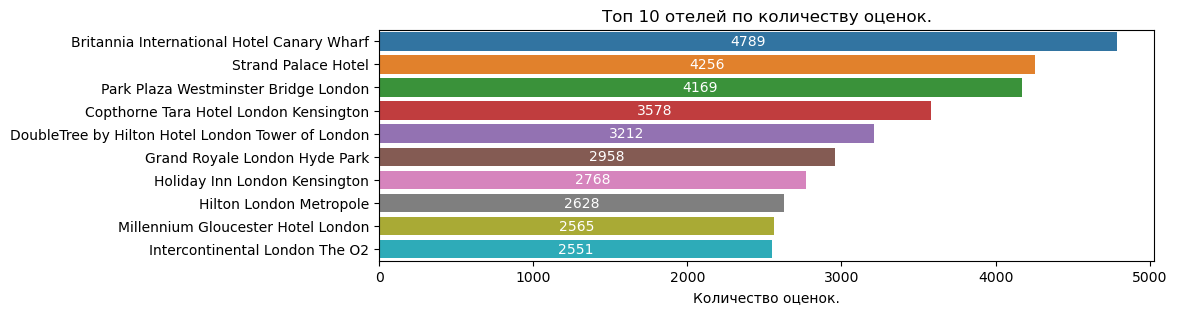

In [6]:
fig, ax = plt.subplots(figsize=(10,3))

df_for_this_plot = incoming_df.groupby(['hotel_name'])['reviewer_score'].count().sort_values(ascending=False).head(10).reset_index()

sns.barplot(df_for_this_plot,
            y='hotel_name',
            x='reviewer_score',
            orient='h')

ax.set_xlabel('Количество оценок.')
ax.set_ylabel('')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='center', color='white')
ax.set_title('Топ 10 отелей по количеству оценок.');

[to contents](#contents)


---
# Первый блок исследований <a id='firstresearchblock'></a>

In [7]:
booking_df = incoming_df.copy()


---
## Разбор первой группы признаков. <a id='fstcolgroup'></a>
> `hotel_name`, `hotel_adress`, `reviewer_nationality`, `lat`, `lng`

Тут всё, как у всех. Ничего не обычного. Не понятно, зачем мне страна, если есть город и наоборот.) Индекс и заполнение нанок достоверными данными - считаю лишними действиями. Я и без того тут лишнего наворотил, потратив тонну времени.))

In [8]:
# Здесь формируется список 3-х последних слов столбца hotel_adress.
three_words_from_hotel_adress = booking_df['hotel_address'].apply(lambda x: ' '.join(re.findall(r'\b([a-zA-Z.]+)\b', x)).split(' ')[-3:] if 'Kingdom' in x else ' '.join(re.findall(r'\b([a-zA-Z.]+)\b', x)).split(' ')[-2:])

# Здесь извлекается город и страна из столбца hotel_adress.
booking_df['hotel_town'] = three_words_from_hotel_adress.str[0].str.strip()
booking_df['hotel_country'] = three_words_from_hotel_adress.str[1:].apply(lambda x: ' '.join(x)).str.strip()

# Тут же я создаю отдельный столбец, в котором сравниваю: является ли посетитель отеля гражданином страны, в которой находится отель.
booking_df['is_citizen'] = booking_df.apply(lambda x: 1 if x['reviewer_nationality'].strip() == x['hotel_country'] else 0, axis=1)

# Сразу сделаю столбцы для каждого города.
booking_df = pd.concat([booking_df, pd.get_dummies(booking_df['hotel_town']).apply(lambda x: x.astype(int))], axis=1)

# Список названий отелей, в столбцах которые есть нанки.
list_of_hotel_address_with_nan = list(booking_df.loc[booking_df.isna().any(axis=1), 'hotel_address'].value_counts().index)
# Но не буду заморачиваться с подрезанием готового словаря с работ кагла, как и с геопу. 
# Как и с дистанцией от центра. Это не особо повлияет на результат. 
# Я и так уже мощно заморочился.. с текстом. Это жесть, конечно.
booking_df = booking_df.fillna(0)

# Возьму столбец с отрицательными числами по модулю. Там ругаются на негативные числа в хи квадрате.
booking_df['lng'] = booking_df['lng'].abs()

Порубил адрес на город, страну.  
Определил гражданство.  
За-думкал город по столбцам.  
И заполнил нанки нулями.  
Взял `lng` по модулю.

[to contents](#contents)


---
## Разбор второй группы признаков. <a id='scndcolgroup'></a>
> `reviewer_date`, `days_since_review`

И здесь тоже то же. 

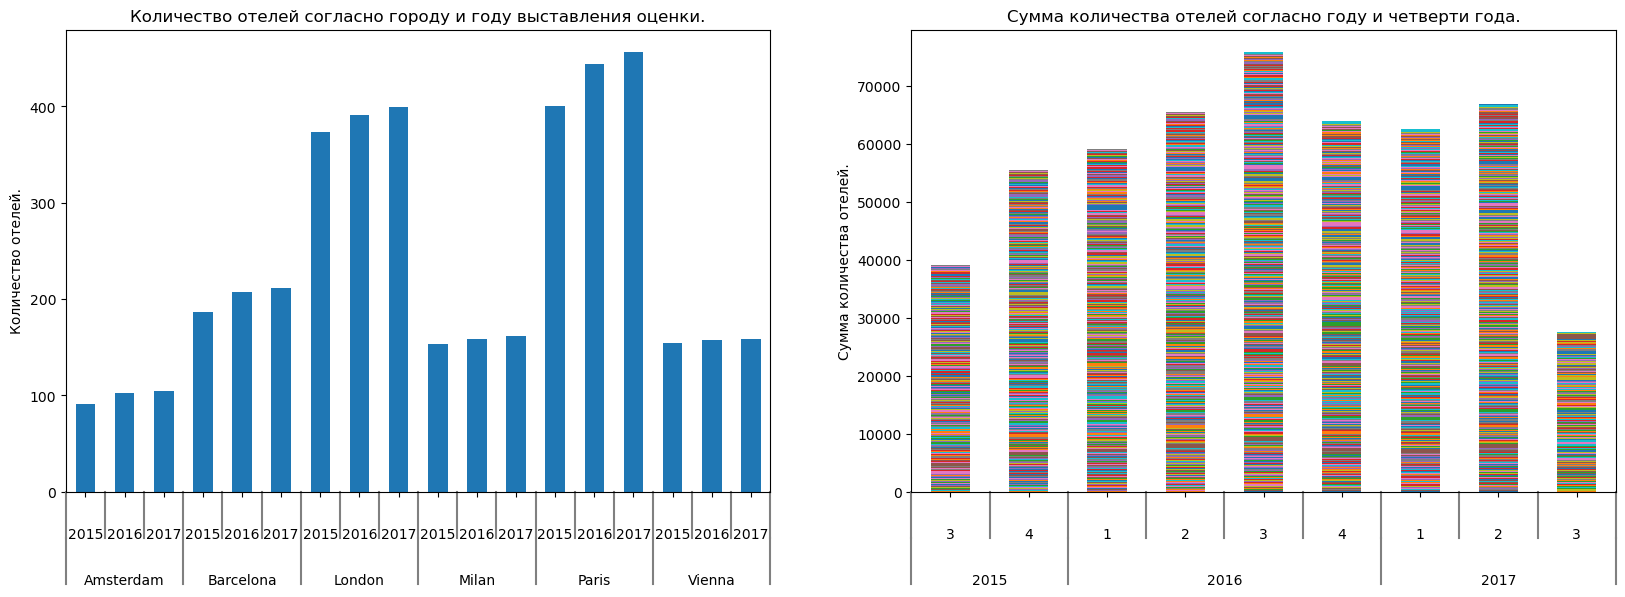

In [9]:
# Выделяю год и квартал из столбца с датами.
booking_df['review_date'] = pd.to_datetime(booking_df['review_date'])
booking_df['year_of_review'] = booking_df['review_date'].dt.year.astype(int)
booking_df['quarter_of_review'] = booking_df['review_date'].dt.quarter.astype(int)

# Оставляю только цифры из столбца days_since_review.
booking_df['days_since_review_int'] = booking_df['days_since_review'].str.split(' ').str[0].astype(int)

###########################################################################################################################################

# Здесь происходит подсчёт количества оценённых отелей согласно городу отеля и году его оценки. И занесение данных в отдельный столбец.
booking_df['num_of_graded_hotels_by_year'] = booking_df.groupby(['hotel_town', 'year_of_review'])['hotel_name'].transform('nunique') # f_classif = 87 мощь!))
    
# Здесь я подсчитываю количество оценок в зависимости от города отеля, года отзыва и имени отеля. И заношу эти данные отдельным столбцом.
booking_df['num_of_grades_by_ht_y_hn'] = booking_df.groupby(['hotel_town', 'year_of_review', 'hotel_name'])['average_score'].transform('count') # f_classif = 143

###########################################################################################################################################

# Пара графиков, которые сподвигли меня вообще на группировку по времени.

# Первый график показывает количество отелей, которые оценили в том или ином городе, в тот или иной год. Уникальное количество.
df_for_this_cell_1 = booking_df.groupby(['hotel_town', 'year_of_review'])['hotel_name'].nunique()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))

df_for_this_cell_1.plot(kind='bar', ax=ax[0], stacked=False, legend=False) # Стройка.

ax[0].set_xticklabels('') # обязательно удаление названий по оси х
ax[0].set_xlabel('')
ax[0].set_ylabel('Количество отелей.')
ax[0].set_title('Количество отелей согласно городу и году выставления оценки.')

label_group_bar_table(ax[0], df_for_this_cell_1) # Это чисто декоратор, чтоб метки по оси х отображались ок.

# Второй график расскажет о том, что временной ряд не полный. четверти 2015 и 2017 годов были обрублены, потому сложно определить динамику.
df_for_this_cell_2 = booking_df.groupby(['year_of_review', 'quarter_of_review', 'hotel_name'])['average_score'].count().unstack()

df_for_this_cell_2.plot(kind='bar', ax=ax[1], stacked=True, legend=False) # Стройка. Тут стак - тру, чтоб полосочки складывались и был 1 столбик.

ax[1].set_xticklabels('') # обязательно удаление названий по оси х
ax[1].set_xlabel('')
ax[1].set_ylabel('Сумма количества отелей.')
ax[1].set_title('Сумма количества отелей согласно году и четверти года.')

label_group_bar_table(ax[1], df_for_this_cell_2)

В качестве вывода по второй группе отмечу:
- Выделен год и четверть из признака `'review_date'`, так же сам этот признак приведён к дэйттайм типу;
- был сформирован числовой признак `'days_since_review_int'`, в котором была выделена числовая часть из аналогичного входящего признака;
- был сформирован числовой признак подсчёта количества отелей, согласно городу и году + график;
- -||-, в котором находится количество оценок, согласно городу, году и названию отеля;

На самом деле, второй график показывает только факт того, что таблица как будто бы обрезана по четвертям. И полноценный год, показывающий полноту картины - 2016-й. Но так же можно увидеть увеличение количества оценённых отелей в 4-й четверти 15 vs 16 годов, а так же 1,2 четверти 16 и 17 годов соответственно. 3-я четверть 17 года, имхо, обрублена. Она должна быть больше, т.к. в 16 году самая рыбная четверть = третья. (Жаль нет статистики за предыдущие годы.) Чтобы было проще воспринимать этот график.. Например в 2015 году с июля по сентябрь (3-я четверть года) было поставлено в сумме средних оценок - 29235.0 баллов всем отелям, которые находятся в таблице. (а, делал по трейну, там может уже другое число)

[to contents](#contents)


---
## Разбор третьей группы признаков. <a id='thrdcolgroup'></a>
> `tags`

Спустя большое количество времени, я решил сделать несколько тестов, которые наиболее точно описывают всю боль происходящего в этом проекте.  
В данном параграфе находится только быстрый разбор тегов. Сами текстовые столбцы будут разбираться во втором блоке.

In [10]:
# Здесь я привожу тэги к нормальному виду: список с элементами стр.
if booking_df['tags'].apply(lambda x: isinstance(x, str)).any():
    booking_df['tags'] = booking_df['tags'].apply(lambda x: re.findall(r"'([^']*)'", x)).apply(lambda x: [i.strip().lower() for i in x])

# Здесь просто длина каждого списка с тегами в каждой строке.
booking_df['tags_count'] = booking_df['tags'].apply(lambda x: len(x))

# Здесь я посчитал количество тегов согласно городу, году, кварталу и названию отеля.
# Естественно теги не битые. Там жесть.)
booking_df['total_tags_by_tyqn'] = booking_df.groupby(['hotel_town', 'year_of_review', 'quarter_of_review', 'hotel_name'])['tags_count'].transform('sum') # f = 156

Я пробовал бить теги. Потратил на это дохренищи просто времени (самая подходящая из цензурных формулировок), но никакого результата. Кроме классной функции, от которой я кайфанул. Но не использую тут, т.к. бессмысленно.

[to contents](#contents)


---
## Пара слов о выбросах. <a id='outliersfirstblock'></a>

Я не мог пройти мимо темы выбросов, т.к. в курсе была тема по отлову выбросов, аж целыми двумя способами. В курсе выбросы пока игнорируются, потому я не знаю, как правильно их анализирвать, и что вообще с ними делать.  

Знаю только то, что их хорошо видно на коробках. Потому вот коробки всех числовых столбцов данного датафрейма.  
Где-то есть, где-то нет.)  
Есть +/- нормальные распределения, есть логнормальные. Есть сплошные, где только нули и единички, типа is_citizen, London.. А в остальных за-думканых признаках выбросы - это нули.)) А единица на самом деле не выброс.) 

НО!

Строки удалять нельзя, потому оставляю этот момент.

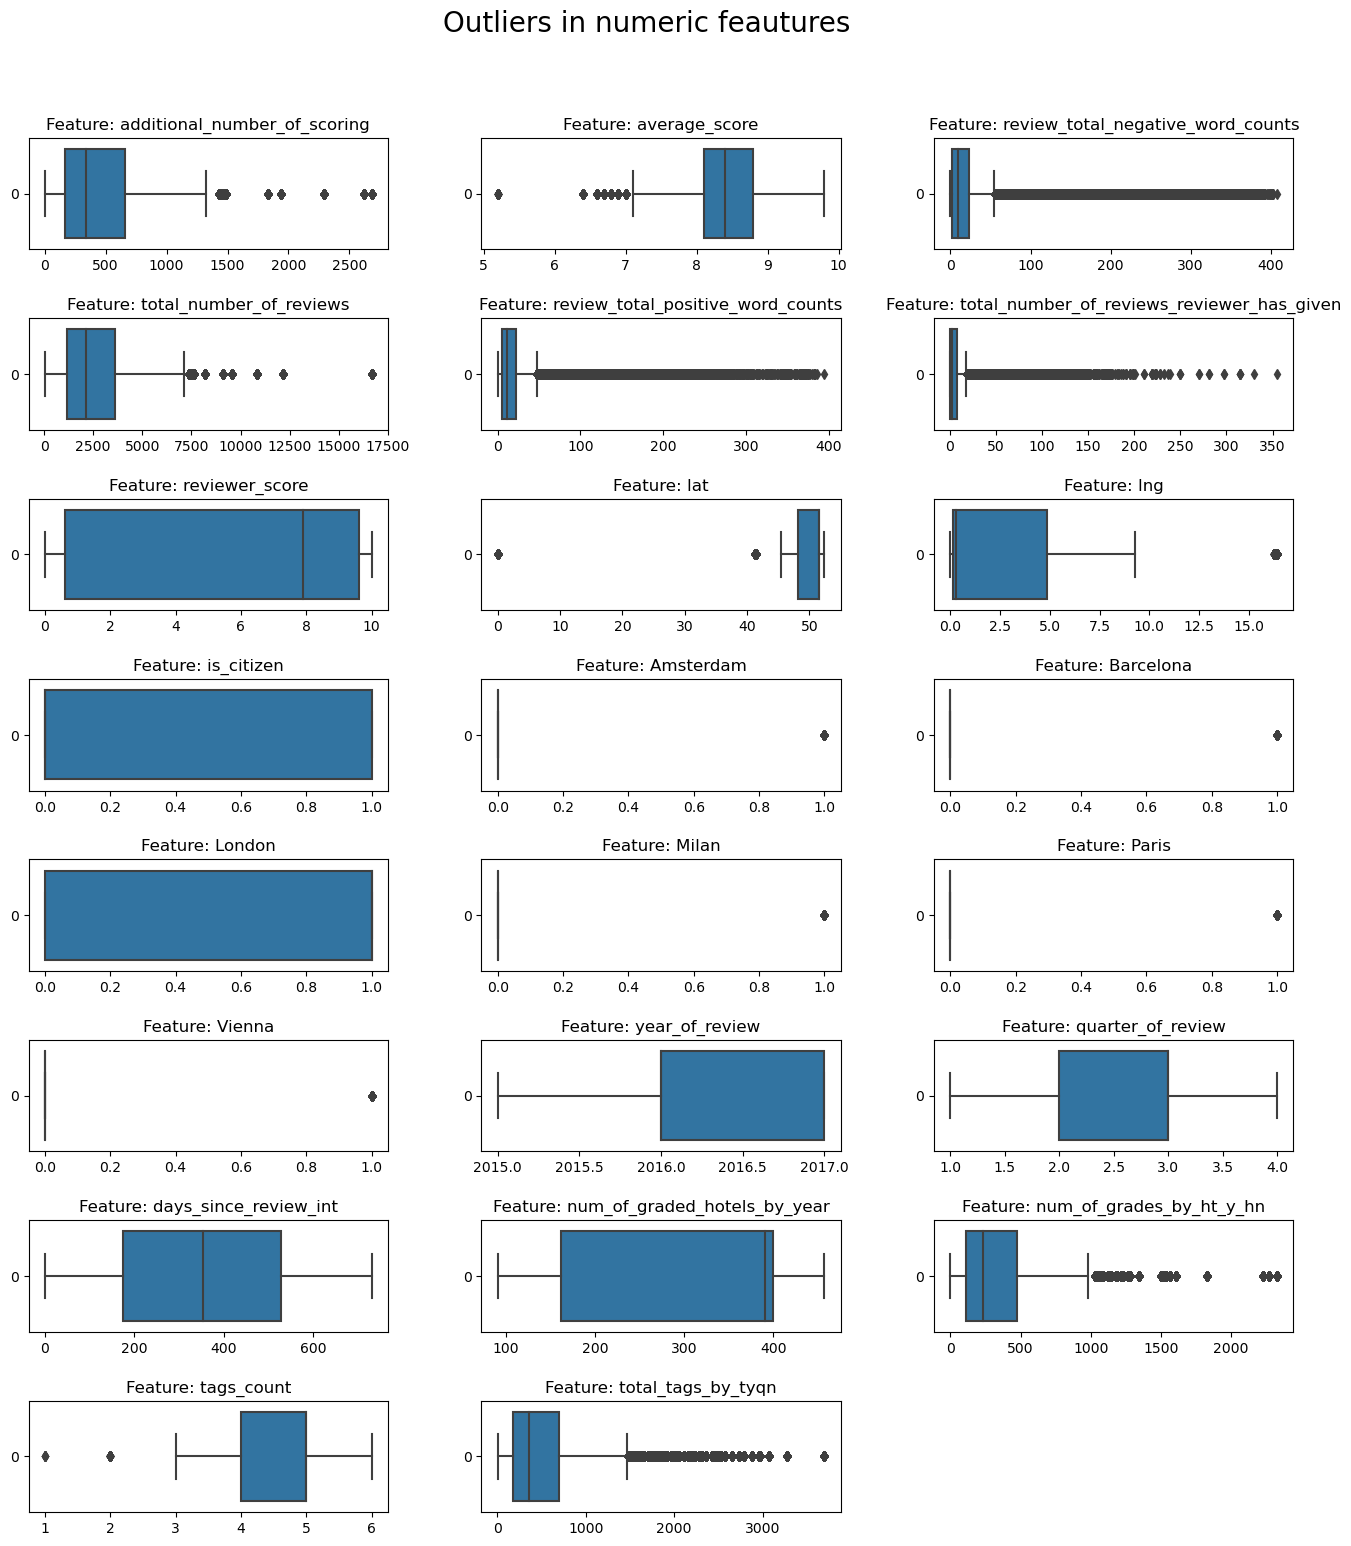

In [11]:
df_for_this_cell = booking_df.select_dtypes(include='number')

nrows = (df_for_this_cell.shape[1] + 2) // 3 
fig, ax = plt.subplots(ncols=3, nrows=nrows, figsize=(14, 16))

plt.suptitle('Outliers in numeric feautures', fontsize=20)

fig.tight_layout(pad=3) # расстояние между подграфиками
plt.subplots_adjust(top=0.9) # чтобы заголовок не налезал на графики

# На каждой итерации рисуется график в определённую ячейку: 0-0, 0-1, 0-2, 1-0 и т.д.
for idx, feature in enumerate(df_for_this_cell.columns):
    row = idx // 3
    col = idx % 3
    
    sns.boxplot(data=df_for_this_cell[feature], ax=ax[row, col], orient='h')
    ax[row, col].set_title(f'Feature: {feature}')
    
# Удаляем пустые subplot'ы
for i in range(len(df_for_this_cell.columns), nrows*3):
    row = i // 3
    col = i % 3
    fig.delaxes(ax[row, col])

plt.show()

Никаких умозаключений. Всё бессмысленно. Строчки дропать нельзя, по другому я не умею избавляться от выбросов. Ни нормализация, ни стандартизация, ни логарифмирование не привели к уменьшению показателя `mape`.

[to contents](#contents)


---
## Разбор четвёртой группы признаков. <a id='fourthcolsgroup'></a>
> `total_number_of_reviews_reviewer_has_given`, `total_number_of_reviews`, `additional_number_of_scoring`  
> а так же: `review_total_negative_word_counts` и `review_total_positive_word_counts`.

В последней группе представлены производные числовые столбцы.  

Не до конца понятно, по каким столбцам производилась группировка, которая привела к этим цифрам: `total_number_of_reviews_reviewer_has_given`.  

Так же не понятно, как они считали `total_number_of_reviews`.   
Как и не понятно, как они считали количество этого столбца: `additional_number_of_scoring`.  
(Окей, по отелям группировали, как и `total_number_of_reviews`.)  

Как и с посчётом положительны и отрицательных слов. Какой функцией люди делали это.. по чему группировали...

Ладно, сделаю копию и посчитаю несколько "сильных" столбцов.

In [12]:
pre_end_df = booking_df.copy()

pd.set_option('display.float_format', '{:.6f}'.format) # пригодится здесь.

Сначала я делал разбор текста здесь же, но потом обратил внимание, что каждый новый групбай лишь ухудшает картину, после применения работы двух алгоритмов к текстовым столбцам. Но оставлю в закомменченом виде, чтоб вспоминать, как оно было в начале.)

In [13]:
# Просто рандомные групбаи. 
pre_end_df['strong_col_1'] = pre_end_df.groupby(['average_score'])['review_total_negative_word_counts'].transform('mean') # f_classif = 7335
pre_end_df['strong_col_2'] = pre_end_df.groupby(['hotel_town', 'year_of_review', 'hotel_name'])['review_total_negative_word_counts'].transform('mean') # f_classif = 3579 lol
#pre_end_df['strong_col_3'] = pre_end_df.groupby(['hotel_town', 'year_of_review', 'hotel_name', 'review_total_negative_word_counts'])['negative_review_roberta_neg'].transform('mean') # 3383 (заменить на mean)
#pre_end_df['strong_col_4'] = pre_end_df.groupby(['negative_review_roberta_neg'])['tags_count'].transform('sum') # 11960
#pre_end_df['strong_col_5'] = pre_end_df.groupby(['hotel_town', 'year_of_review', 'hotel_name', 'negative_review_roberta_neg'])['tags_count'].transform('nunique') # 9239
#pre_end_df['strong_col_6'] = pre_end_df.groupby(['hotel_town', 'year_of_review', 'hotel_name', 'negative_review_roberta_neg'])['tags_count'].transform('nunique') / pre_end_df.groupby(['average_score'])['review_total_negative_word_counts'].transform('mean') # f_classif = 12663
pre_end_df['strong_col_7'] = pre_end_df.groupby(['review_total_negative_word_counts'])['total_number_of_reviews_reviewer_has_given'].transform('nunique') / pre_end_df.groupby(['average_score'])['review_total_negative_word_counts'].transform('mean') # 17709
#pre_end_df['strong_col_8'] = pre_end_df.groupby(['review_total_positive_word_counts'])['negative_review_neg'].transform('mean') / pre_end_df.groupby(['average_score'])['review_total_positive_word_counts'].transform('mean') # 12491
pre_end_df['strong_col_9'] = pre_end_df.groupby(['review_total_positive_word_counts'])['additional_number_of_scoring'].transform('mean') / pre_end_df.groupby(['total_number_of_reviews'])['average_score'].transform('mean') # 11215

# Здесь происходит подсчёт всех слов/не слов в негативном отзыве, разбитых по пробелу.
pre_end_df['strong_col_10'] = np.log(pre_end_df['negative_review'].str.strip().str.split(' ').apply(lambda x: len(x))) # 14421

# Сильный признак, но не поможет оно.
pre_end_df['review_total_word_counts'] = pre_end_df['review_total_positive_word_counts'] + pre_end_df['review_total_negative_word_counts']
pre_end_df['strong_col_11'] = pre_end_df.apply(lambda row: 0.5 if row['review_total_word_counts'] == 0 else row['review_total_positive_word_counts'] / row['review_total_word_counts'], axis=1) # 23956

Я подумал, как бы мне так посмотреть на силу влияния, не добавляя столбцы в таблицу. Чтоб сразу хлобысь и протестировал. Ведь по сути мы придумываем наборы чисел, которые взаимосвязаны с последовательностью целевого набора чисел. И исходя из этого я попытался дополнить имеющиеся наборы - группировкой по этим наборам, которая, как мне показалось, поможет показать движение для выявления закономерностей. Но всё впустую. Видимо я так ничего и не понял.

In [14]:
df_for_this_cell = pre_end_df['strong_col_11']
df_for_this_cell_2 = pre_end_df.groupby(['review_total_negative_word_counts'])['total_number_of_reviews'].transform('nunique') / pre_end_df.groupby(['average_score'])['review_total_negative_word_counts'].transform('mean') # 16284

print('Тестирование массива чисел на силу влияния на целевой столбец:')
display(f_classif_chi_tester(df_for_this_cell, pre_end_df['reviewer_score']))
print(f'Корреляция между двумя массивами чисел: {df_for_this_cell.corr(other=df_for_this_cell_2)}')

Тестирование массива чисел на силу влияния на целевой столбец:


f     18921.069856
chi   25687.105492
dtype: float64

Корреляция между двумя массивами чисел: 0.5333291128506447


In [15]:
df_for_this_cell = pre_end_df.groupby(['review_total_negative_word_counts'])['total_number_of_reviews_reviewer_has_given'].transform('nunique') / pre_end_df.groupby(['average_score'])['review_total_negative_word_counts'].transform('mean') # 17709
df_for_this_cell_2 = (pre_end_df.groupby(['review_total_negative_word_counts'])['total_number_of_reviews_reviewer_has_given'].transform('nunique') / pre_end_df.groupby(['average_score'])['review_total_negative_word_counts'].transform('mean')).apply(lambda x: np.log(x) if x != 0 else x)

print('Сравнение силы влияния до логарифмирования и после:')
display(pd.concat([f_classif_chi_tester(df_for_this_cell, pre_end_df['reviewer_score']), f_classif_chi_tester(df_for_this_cell_2, pre_end_df['reviewer_score'])], axis=1, keys=['before', 'after']))

Сравнение силы влияния до логарифмирования и после:


,before,after
f,14493.038911,14272.862571
chi,98144.808838,11587.474139


В ячейке ниже лежит пример фильтрации датафрейма через ф-классиф. Т.е. обрубаются столбцы, ф-классиф которых < 4k.  
Просто оставлю тут, ибо полезная штука, потом забуду.

In [16]:
pre_end_df[pre_end_df.select_dtypes(include='number').columns[pd.Series(f_classif(pre_end_df.select_dtypes(include='number').fillna(0), pre_end_df['reviewer_score'].astype(int))[0]) > 4000]].head(3)

,average_score,review_total_negative_word_counts,reviewer_score,strong_col_1,strong_col_7,strong_col_9,strong_col_10,strong_col_11
0,8.400000,3,10.000000,18.765271,5.755313,62.292396,0.000000,0.571429
1,8.300000,3,6.300000,19.584489,5.514568,66.446549,0.693147,0.400000
2,8.900000,6,7.500000,15.379102,7.217586,62.121863,1.386294,0.000000


Вывода у четвёртой группы нет.  

Но отмечу лишь тот момент, что все подсчёты `f_classifa` (которые я выписывал для себя через #) я делал только по `трейну`, потому цифры больше.  
По совмещённому с `тестом` - цифры меньше. Лениво пересчитывать. (это специально для душнил, мол у меня там написано, что `strong_col_11` на `f_classif` = 23956, а чуть ниже 18921. Потому что я с `тестом` совместил `трейн` и `f_classif` снизился)  
Вероятней всего, потому что в `тесте` в столбце `reviewer_score` - нули.))

[to contents](#contents)


---
## Экспресс отбор <a id='fblselection'></a>

Взглянем на силу сформированных столбцов при помощи теста `f_classif`. Он наиболее честный. Не видел ещё ни одного столбца, который был бы сильный по версии `хи квадрата` и как-то влиял на обучение модели. Но, опять же, в рамках этого проекта. Возможно я перебрал не все возможные комбинации столбцов, хз. Да и `f_classif` не особо то и влияет, но он хотя бы соответствует методу `.feature_importances_` после обучения.

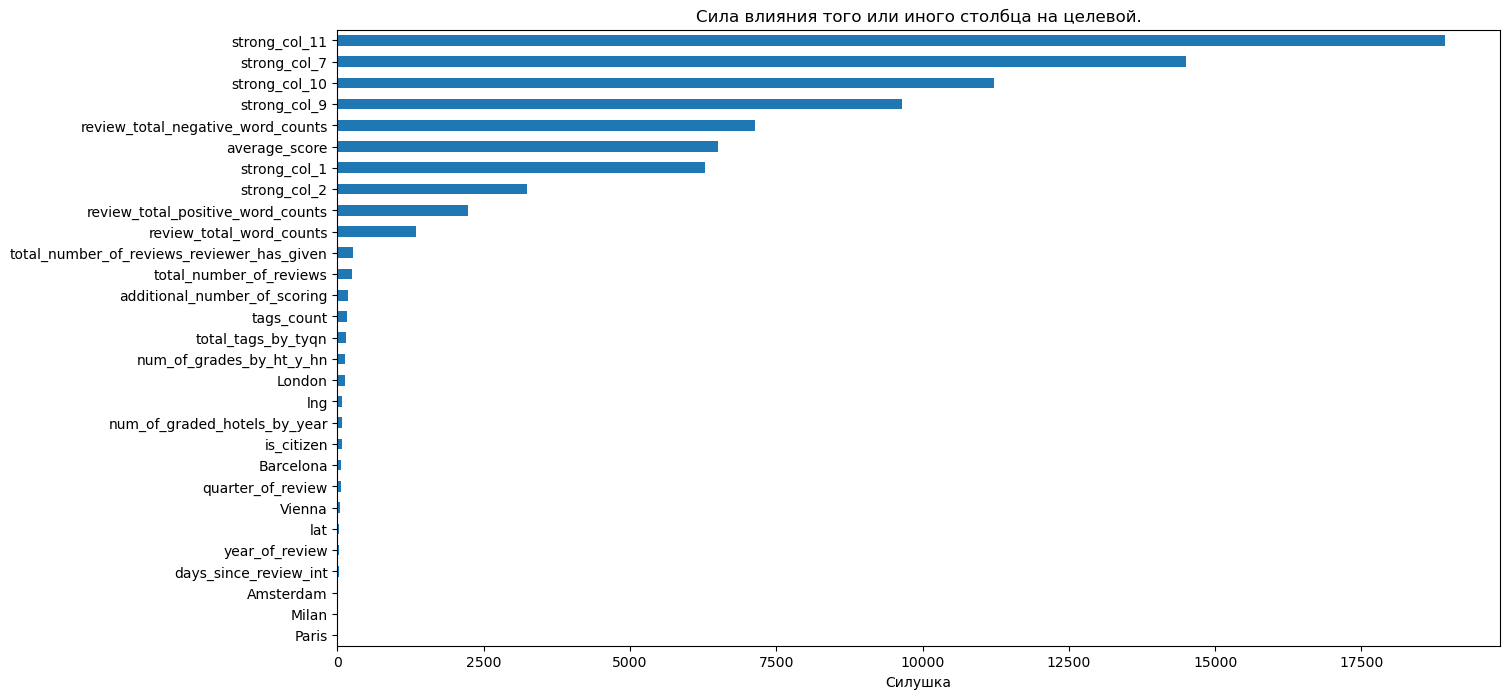

In [17]:
# Выбираю только числовые столбцы. Удобная вещь, пипец.)
ax = f_classif_chi_tester(pre_end_df.select_dtypes(include='number'), pre_end_df['reviewer_score']) \
    .loc[:, 'f_classif'] \
        .sort_values() \
            .plot(kind='barh', figsize=(15,8))
ax.set_xlabel('Силушка')
ax.set_title('Сила влияния того или иного столбца на целевой.');

Казалось бы, сильные столбцы, классно влияют на целевой. Подсчёт негативных слов в топе, как и средняя оценка. Хотя бы полпроцента скинь!!!))

`Average_score` - на самом деле очень сомнительный столбец. Понятно, что его считали через группировку отелей, но за какой период, не понятно. Везде цифры разные, как и длина массива чисел после группировки и мерджа. Об этом в бонусе.)

Ниже график распределений этих "сильных" столбцов относительно целевого.

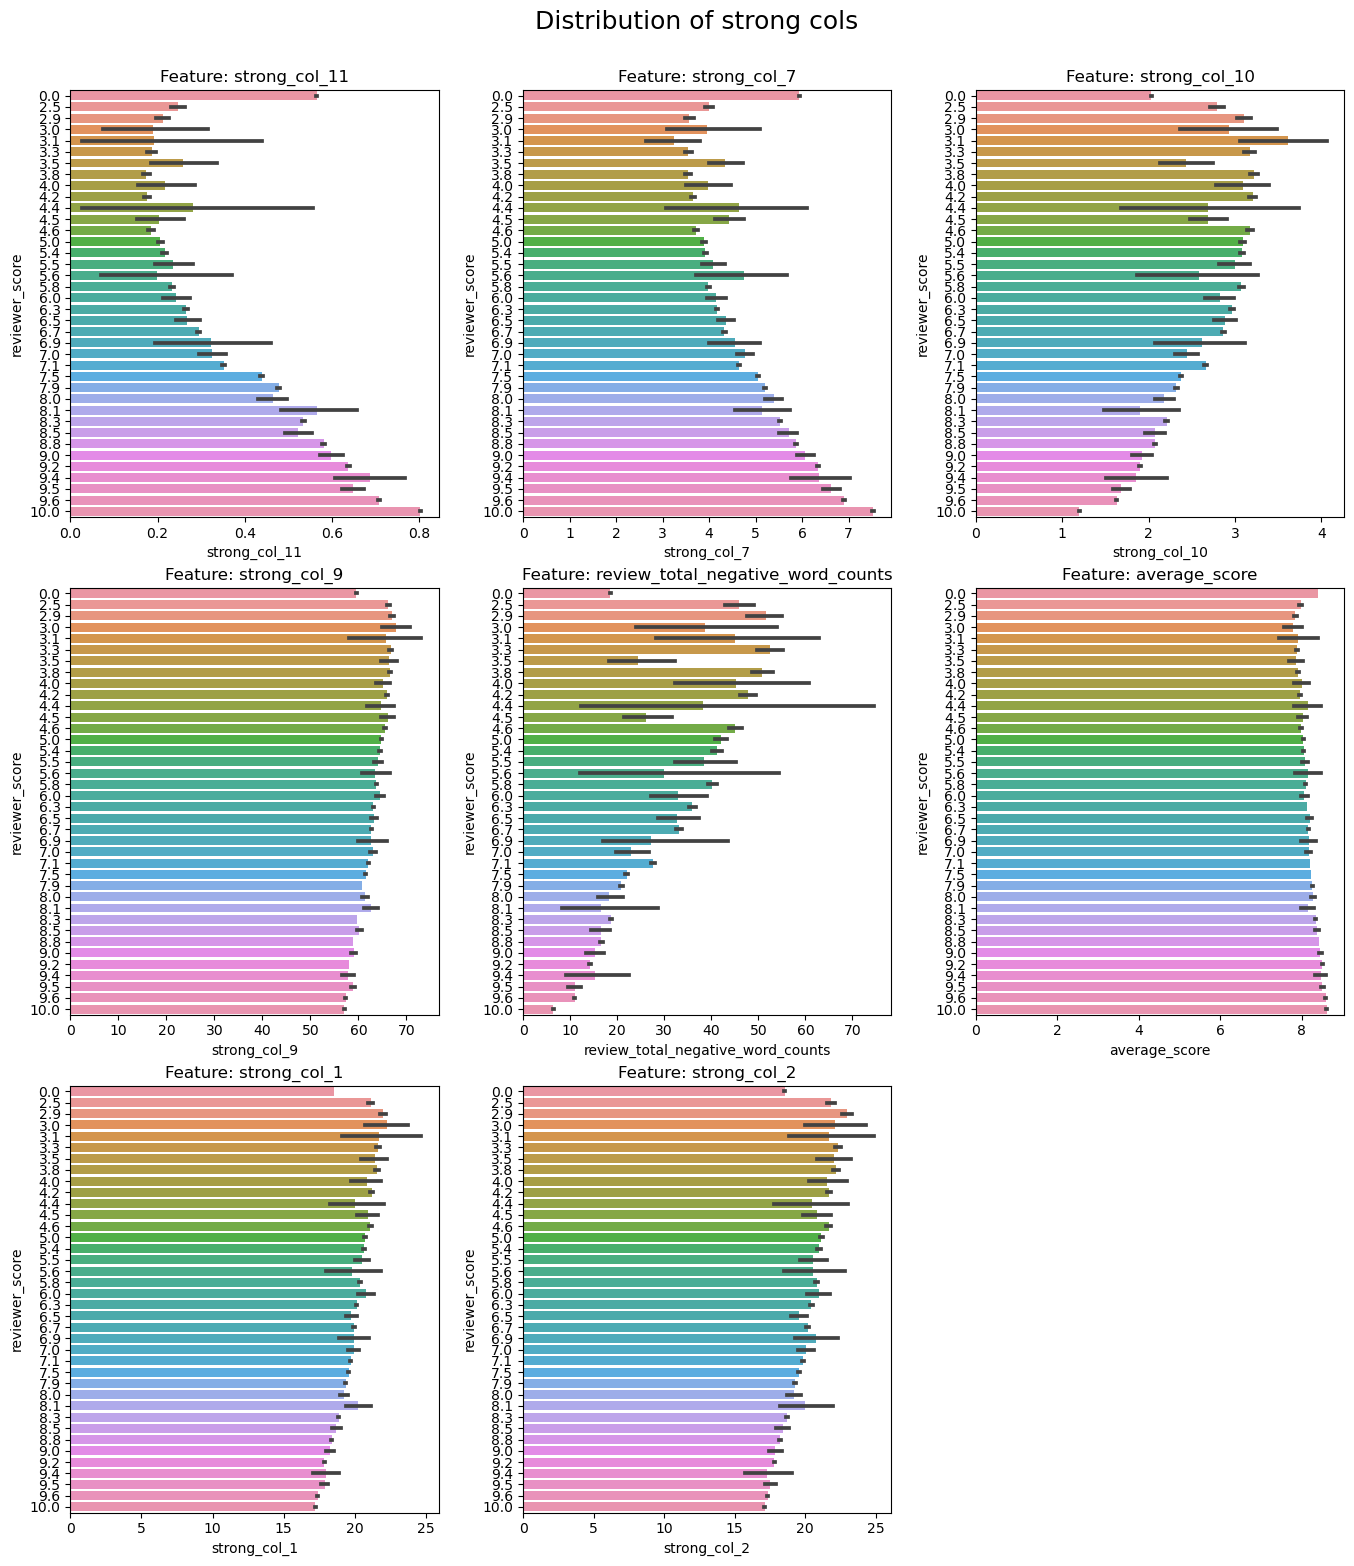

In [18]:
# Отбираем имена первых 8-ми самых типа сильных столбцов.
list_of_strong_cols = f_classif_chi_tester(pre_end_df.select_dtypes(include='number'), pre_end_df['reviewer_score']).loc[:, 'f_classif'].sort_values(ascending=False).head(8).index
# Формируем дф-чик по этим именам.
df_for_this_cell = pre_end_df[list_of_strong_cols]
# Целевой столбец.
targ_col = 'reviewer_score'

##########################################################################################################################################

nrows = (df_for_this_cell.shape[1] + 2) // 3 
fig, ax = plt.subplots(ncols=3, nrows=nrows, figsize=(14, 16))

plt.suptitle('Distribution of strong cols', fontsize=18)

fig.tight_layout(pad=3) # расстояние между подграфиками
plt.subplots_adjust(top=0.93) # чтобы заголовок не налезал на графики

# На каждой итерации рисуется график в определённую ячейку: 0-0, 0-1, 0-2, 1-0 и т.д.
for idx, feature in enumerate(df_for_this_cell.columns):
    row = idx // 3
    col = idx % 3
    
    sns.barplot(data=pre_end_df, x=feature, y=targ_col, orient='h', ax=ax[row, col]);
    ax[row, col].set_title(f'Feature: {feature}')
    
# Удаляем пустые subplot'ы
for i in range(len(df_for_this_cell.columns), nrows*3):
    row = i // 3
    col = i % 3
    fig.delaxes(ax[row, col])

plt.show()

Я уже так устал от бесконечного ковыряния этого датасета, что я не знаю, что написать про распределение. Как мне кажется - там должна быть ровная такая экспонента. Т.е. плавное возрастание или плавное убывание без резких перепадов.

Так же взглянем на матрицу корреляции и определим сильно скоррелированные столбцы:

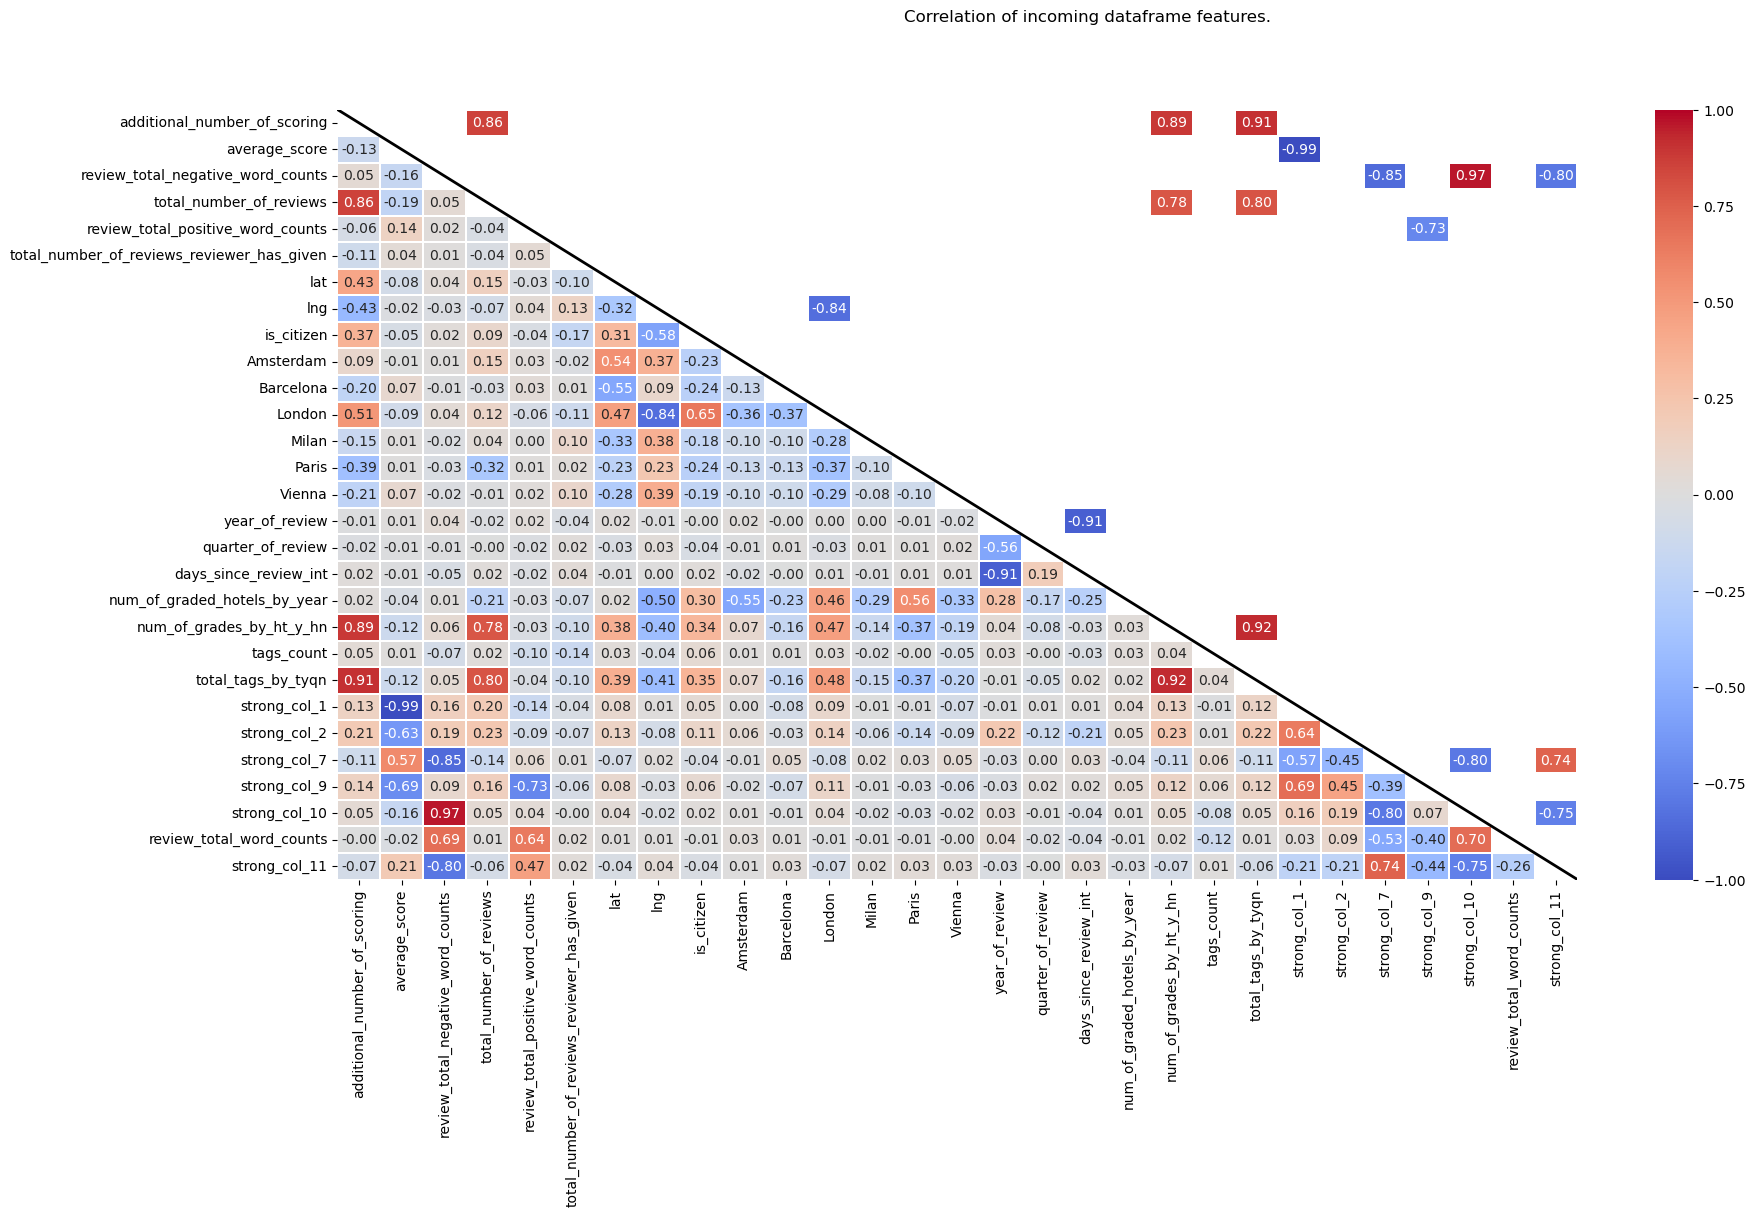

In [19]:
my_corr(df=pre_end_df.select_dtypes(include='number').drop('reviewer_score', axis=1),
        corrneg=-0.7,
        corrpos=0.7,
        figsize=(20,10));

Такс. Выше 0.7 есть несколько штук, глянем на названия:

In [20]:
my_corr(df=pre_end_df.select_dtypes(include='number').drop('reviewer_score', axis=1),
        corrneg=-0.7,
        corrpos=0.7,
        show_high_corr_cols_names=True)

,level_0,level_1,corr
0,review_total_negative_word_counts,strong_col_10,0.965905
1,num_of_grades_by_ht_y_hn,total_tags_by_tyqn,0.923447
2,additional_number_of_scoring,total_tags_by_tyqn,0.908549
3,additional_number_of_scoring,num_of_grades_by_ht_y_hn,0.889941
4,additional_number_of_scoring,total_number_of_reviews,0.859014
5,total_number_of_reviews,total_tags_by_tyqn,0.796049
6,num_of_grades_by_ht_y_hn,total_number_of_reviews,0.784275
7,strong_col_11,strong_col_7,0.740266
8,review_total_positive_word_counts,strong_col_9,-0.725614
9,strong_col_10,strong_col_11,-0.752333


Лондон из зе кепитал оф Грейт Британ!!))

Дропнем всё, на мой взгляд, лишнее.  
И сразу подготовлю окончательный датафрейм для использования его в модели.  
Т.е. выберу только `train` данные, выберу только числовые столбцы и дропну сильно скоррелированные.

In [21]:
end_df = pre_end_df \
    .query('sample == "train"') \
        .select_dtypes(include='number') \
            .drop(columns=[#'average_score', 'review_total_negative_word_counts', 'total_tags_by_tyqn',
                           #'positive_review_neu', 'positive_review_roberta_neu', 
                           #'strong_col_5', 'strong_col_2', 'strong_col_4', 'strong_col_11', 'strong_col_13',
                           'total_number_of_reviews', 'average_score', 'strong_col_10',
                           'review_total_negative_word_counts', 'additional_number_of_scoring', 'num_of_grades_by_ht_y_hn',
                           'lng', 'days_since_review_int'])

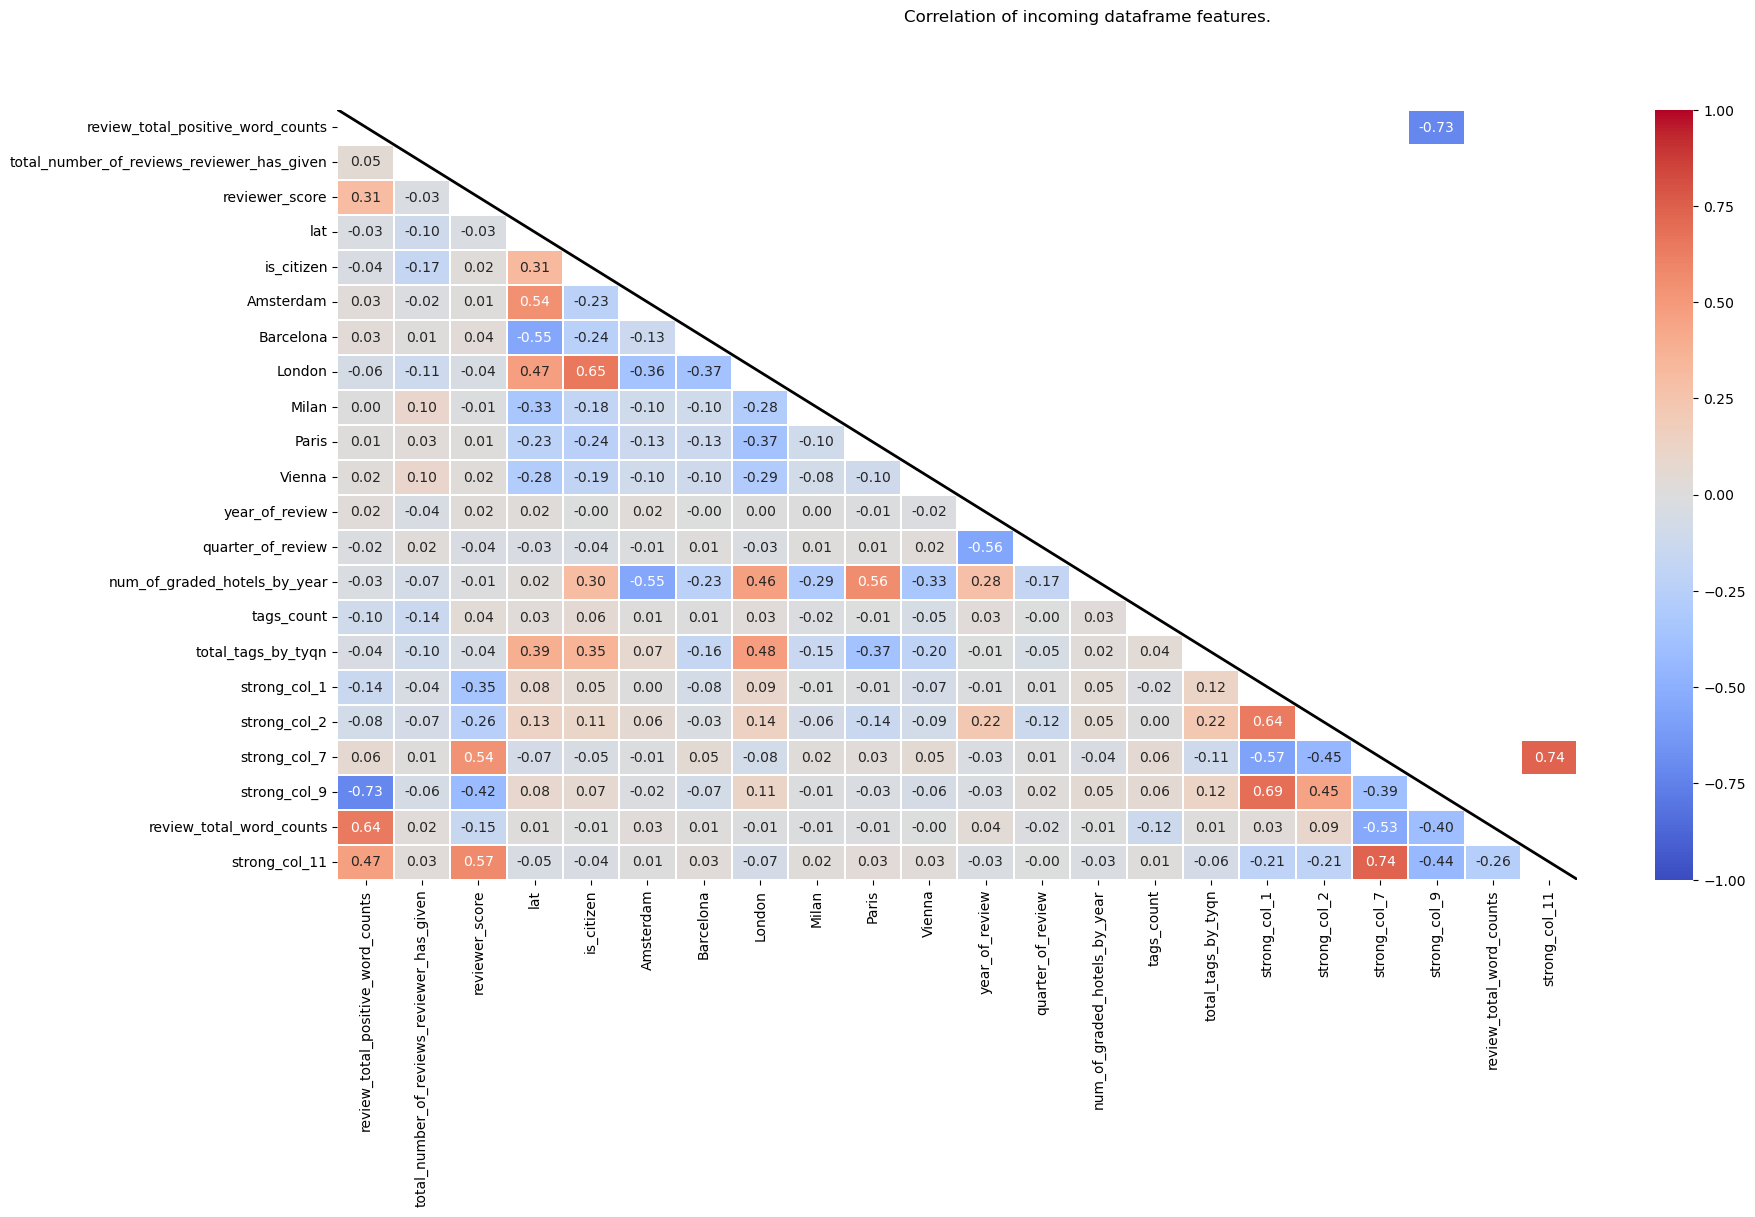

In [22]:
my_corr(end_df, corrneg=-0.7, corrpos=0.7, figsize=(20,10));

Оставлю -0.72 и 0.74. Вот так решил.

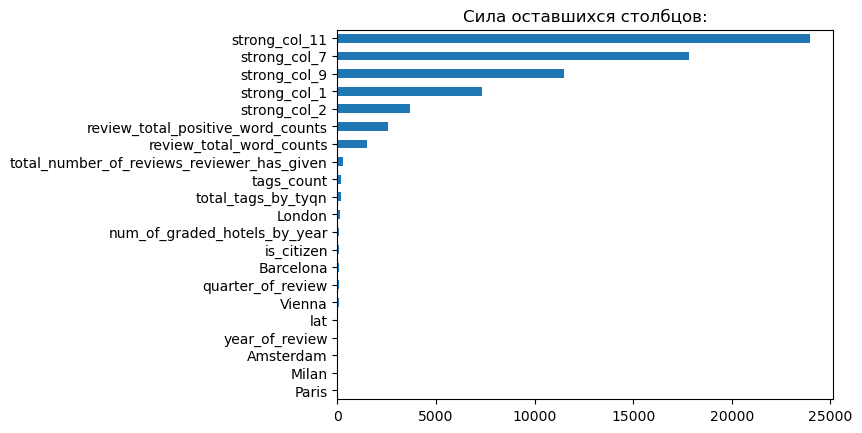

In [23]:
ax = f_classif_chi_tester(end_df, end_df['reviewer_score']).loc[:, 'f_classif'].sort_values().plot(kind='barh')
ax.set_title('Сила оставшихся столбцов:');

In [24]:
# Это всё не поможет.
#end_df['year_of_review'] = pd.Series(preprocessing.RobustScaler().fit_transform(end_df['year_of_review'].to_frame()).flatten())
#end_df['num_of_graded_hotels_by_year'] = pd.Series(preprocessing.RobustScaler().fit_transform(end_df['num_of_graded_hotels_by_year'].to_frame()).flatten())
#end_df['num_of_grades_by_ht_y_hn'] = pd.Series(preprocessing.RobustScaler().fit_transform(end_df['num_of_grades_by_ht_y_hn'].to_frame()).flatten())
#end_df['total_number_of_reviews'] = pd.Series(preprocessing.RobustScaler().fit_transform(end_df['total_number_of_reviews'].to_frame()).flatten())
#end_df['lat'] = pd.Series(preprocessing.RobustScaler().fit_transform(end_df['lat'].to_frame()).flatten())
#end_df['additional_number_of_scoring'] = pd.Series(preprocessing.RobustScaler().fit_transform(end_df['additional_number_of_scoring'].to_frame()).flatten())

[to contents](#contents)


---
## Тренировка модели <a id='firblotraining'></a>

Здесь, в ячейке ниже, удобно располагается тренировка модели изначальной `train` таблицы, без каких либо манипуляций. Просто числовые столбцы.  
Тренировку провожу алгоритмом ускоренной кошки, т.к. изначально знаю, что этот алгоритм для данной задачи самый ок.

In [25]:
y = incoming_df.query('sample == "train"').loc[:, 'reviewer_score']
X = incoming_df.query('sample == "train"').select_dtypes(include='number').drop(['reviewer_score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

test_model = CatBoostRegressor(iterations=12000, learning_rate=.1, depth=3, silent = True)

test_model.fit(X_train, y_train)

y_pred = test_model.predict(X_test)

cat_boost = round(metrics.mean_absolute_percentage_error(y_test, y_pred) * 100, 4)
cat_boost

13.4134

А здесь давайте натренируем изменённую таблицу. Блок 1 - экспериментальный, потому выберу только 3 алгоритма для обучения.

In [26]:
# list of names algs

#list_of_ml_algs = ['RandomForestRegressor', 'CatBoostRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'AdaBoostRegressor', 'DecisionTreeRegressor']
list_of_ml_algs = ['RandomForestRegressor', 'CatBoostRegressor', 'ExtraTreesRegressor']

# params for each alg порядок не важен.
params_dict = {
        'RandomForestRegressor': [{'n_estimators': 10, 'n_jobs': -1, 'random_state': 42}, {}],
        'ExtraTreesRegressor': [{'n_estimators': 10, 'max_depth': 3}, {}],
        'CatBoostRegressor': [{'iterations': 12000, 'learning_rate': .1, 'depth': 3, 'verbose': False}, {}]
}

# magic func
models_df = multiple_models_training(end_df, 'reviewer_score', list_of_ml_algs=list_of_ml_algs, params_dict=params_dict)

КОРОЛЬ АРТУР НА НАС НАПАЛИ!!!


Cell progress: : 0%|          | 0/100 [Elapsed: 00:00 m/s]

Model training completed! With: 5.27 sec. Alg: RandomForestRegressor.
Model training completed! With: 1.22 min. Alg: CatBoostRegressor.
Model training completed! With: 0.79 sec. Alg: ExtraTreesRegressor.
Mission accomplished.


Посмотрим на сравнение средних абсолютных ошибок работы нескольких алгоритмов финальной таблицы первого блока.

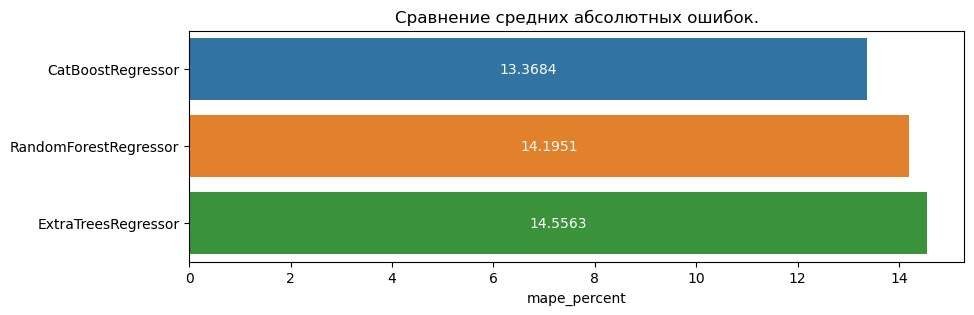

In [27]:
fig, ax = plt.subplots(figsize=(10, 3))

sns.barplot(models_df, x='mape_percent', y='alg_name')

ax.set_title(f'Сравнение средних абсолютных ошибок.')
ax.bar_label(ax.containers[0], fmt='%.4f', label_type='center', color='white')
ax.set_ylabel('');

In [28]:
print(f"Разница в ошибке между изначальной таблицей и изменённой составляет.. тадаам: {round(cat_boost - models_df.loc[models_df['alg_name'] == 'CatBoostRegressor', 'mape_percent'][0], 4)}%")
print('4 месяца потратил, чтобы это выяснить аххахаха')

Разница в ошибке между изначальной таблицей и изменённой составляет.. тадаам: 0.045%
4 месяца потратил, чтобы это выяснить аххахаха


Взглянем, какие столбцы модель сочла сильными, по которым она осуществляла работу:

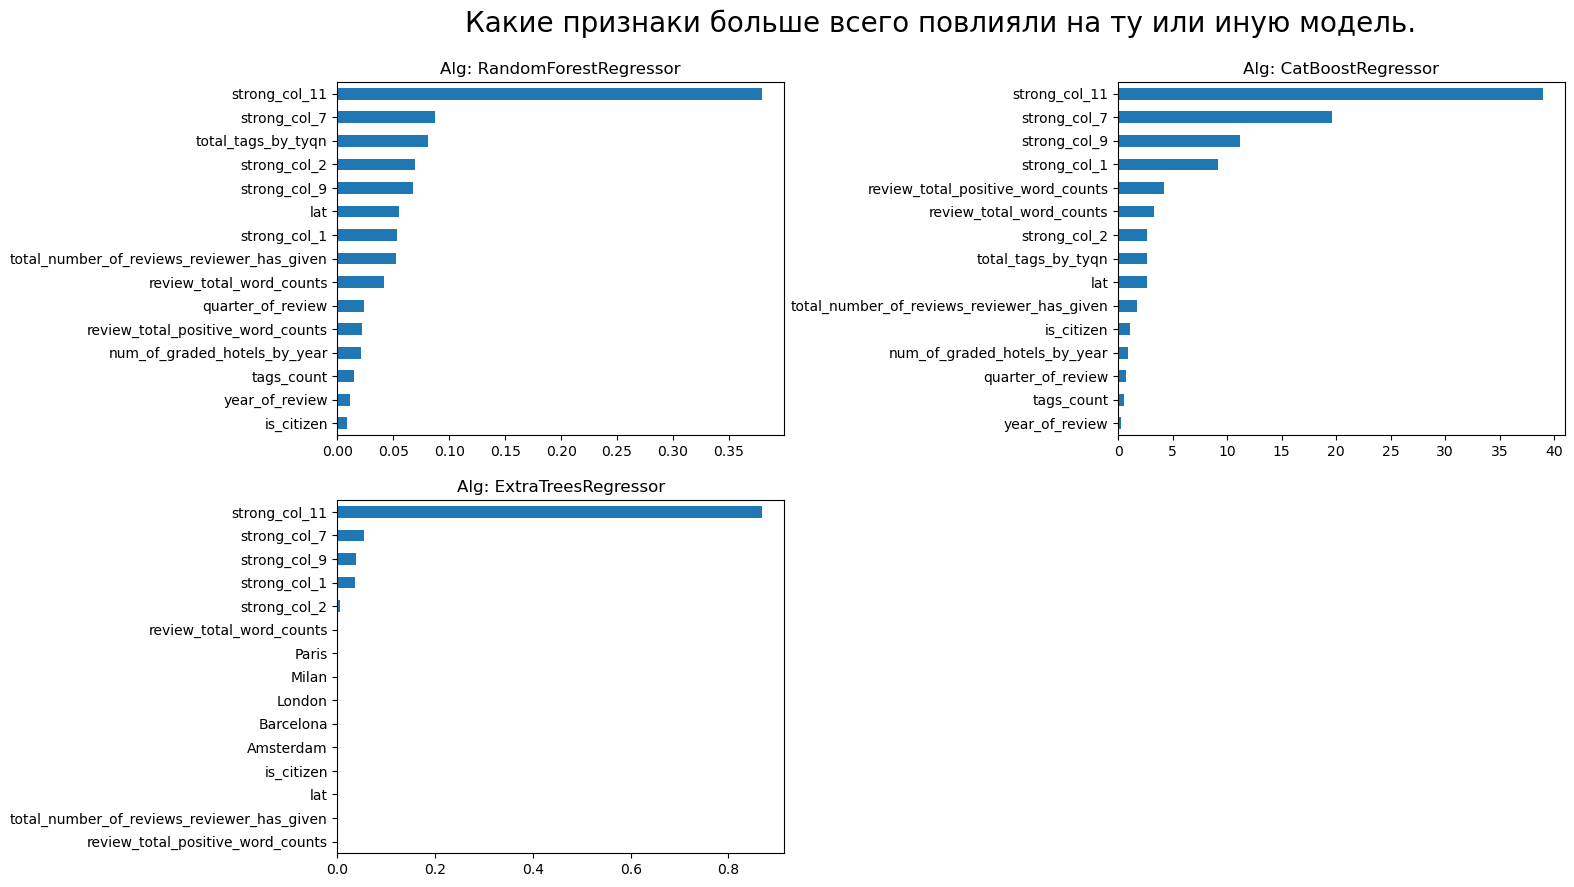

In [29]:
nrows = len(list_of_ml_algs) // 2 if len(list_of_ml_algs) % 2 == 0 else len(list_of_ml_algs) // 2 + 1
fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(13, 9))

row = 0
col = 0

fig.tight_layout(w_pad=21, h_pad=3) # расстояние между подграфиками
plt.subplots_adjust(top=0.9) # чтобы заголовок не налезал на графики

plt.suptitle('Какие признаки больше всего повлияли на ту или иную модель.').set_fontsize(20)

for idx, feature in enumerate(list_of_ml_algs):
    row = idx // 2
    col = idx % 2
    
    feat_importances = pd.Series(models_df.loc[models_df['alg_name'] == feature, 'model'].iloc[0].feature_importances_, index=end_df.drop(columns=['reviewer_score']).columns)
    feat_importances.nlargest(15).sort_values().plot(kind='barh', ax=ax[row, col]);
    
    ax[row, col].set_title(f'Alg: {feature}')
    
# Удаляем пустые subplot'ы
for i in range(len(list_of_ml_algs), nrows*2):
    row = i // 2
    col = i % 2
    fig.delaxes(ax[row, col])

plt.show()

Всё, как и на `f_classif`. Почти.))

В качестве вывода отмечу, что никакие манипуляции из блока 1 не привели к радикальному уменьшению ошибки.

А теперь перейдём ко второму блоку, где я добавлю к изначальной таблице только разбор 2х столбцов: `positive_review` и `negative_review`. Используя несколько алгоритмов разбора текста.

[to contents](#contents)


---
# Второй блок исследований <a id='secondresearchblock'></a>

In [30]:
# Скопирую изначальный дф-ник сюда.
booking_df_2 = incoming_df.copy()

print(f"Что находтся в fillna: {fillna_dict_for_custom_df(booking_df_2, 'median')}")
# Накидаю в нанки медиану.
# Функция возвращает словарь и там что-то типа {'lat': 41.312, 'lng': 0.132}
booking_df_2 = booking_df_2.fillna(fillna_dict_for_custom_df(booking_df_2, 'median'))

print(f"Проверим этот... размерность: {booking_df_2.shape}")

Что находтся в fillna: {'lat': 51.499981, 'lng': 0.010607}
Проверим этот... размерность: (515738, 18)



---
## Обработка текстовых столбцов с отзывами. <a id='textfarming'></a>
> `positive_review` & `negative_review`

Наши немногочисленные текстовые столбцы, потому буду делать импорт тут.

Итак, положительные и отрицательные отзывы я прогоняю через 2 алгоритма: вейдера и роберты. 
Естественно, сам я не додумался, как это лучше сделать, но пипец долго думал. Депрессовал, забивал, возвращался, снова забивал...

Ну и в итоге нашёл чувака на ютабчике, который доступно написал про работу с текстом, хотя там тоже темнейший лес для меня. Я короче просто взял. Вот [ссылка](https://www.youtube.com/watch?v=QpzMWQvxXWk). Результат пушка-бомба.

In [31]:
## Эта ячейка относится к алгоритму вейдера.
## Тоже закомменчу, ниже ответ почему.

#import nltk
#from nltk.sentiment import SentimentIntensityAnalyzer
#
#nltk.download('vader_lexicon')
#
#def vader_sentiment_analysis(df, targ_col):
#    """Функция для формирования датафрейма с определением тональности текста по алгоритму Вейдера.
#    
#    Args:
#        df (pd.DataFrame): incoming df
#        targ_col (str): target column
#
#    Returns:
#        pd.DataFrame: df with neg, neu, pos, compound from Vader.
#        
#        looks like:
#        __|targ_col_neg|targ_col_neu|targ_col_pos|targ_col_comp|
#        0 |         0.1|         0.8|         0.2|         0.64|
#        etc.
#    """
#    
#    # Инит класса.
#    sia = SentimentIntensityAnalyzer()
#    # Словарь для записи результатов.
#    res = {}
#    
#    # Цикл по строкам датафрейма и запись анализа настроения в словарь.
#    for i, text in enumerate(tqdm(df[targ_col], total=len(df))):
#        res[i] = sia.polarity_scores(text)
#    
#    # Переименование столбцов.
#    new_columns = {col: f"{targ_col}_{col}" for col in res[0].keys()}
#    # Возврат дф-ки с решейпом и переименованием столбцов.
#    return pd.DataFrame(res).T.rename(columns=new_columns)
#
## print(SentimentIntensityAnalyzer().polarity_scores('example')) # вместо 'example' любой текст

In [32]:
## Эта ячейка относится к алгоритму роберты 
## (на самом деле я не знаю, алгоритм это или нет, и как вообще называется, что тут происходит, как в ютубе говорили, так и пишу), 
## но я её закомментил, потому что там 15 итераций/сек максимум и один столбец анализируется 9 часов, 
## потому я фоном запустил на кегле и возьму сразу готовый csv файл. Но код - вот этот.
#
#
#def roberta_polarity_scores(df, targ_col):
#    """Функция для формирования датафрейма с определением тональности текста по алгоритму роберты.
#    
#    Args:
#        df (pd.DataFrame): incoming df
#        targ_col (str): target column with text.
#
#    Returns:
#        pd.DataFrame: df with neg, neu, pos from roberta.
#        
#        looks like:
#        __|targ_col_neg|targ_col_neu|targ_col_pos|
#        0 |         0.1|         0.8|         0.2|
#        etc.
#    """
#    
#    from transformers import AutoTokenizer
#    from transformers import AutoModelForSequenceClassification
#    from scipy.special import softmax
#
#    MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
#    tokenizer = AutoTokenizer.from_pretrained(MODEL)
#    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#
#    res = {}
#    for i, text in enumerate(tqdm(df[targ_col], total=len(df))):
#      try:
#        encoded_text = tokenizer(text, return_tensors='pt')
#        output = model(**encoded_text)
#        scores = softmax(output[0][0].detach().numpy())
#        res[i] = {'roberta_neg': scores[0], 'roberta_neu': scores[1], 'roberta_pos': scores[2]}
#      except RuntimeError:
#        print(f'Broke for id: {i}')
#
#    # Переименование столбцов.
#    new_columns = {col: f"{targ_col}_{col}" for col in res[0].keys()}
#    # Возврат дф-ки с решейпом и переименованием столбцов.
#    return pd.DataFrame(res).T.rename(columns=new_columns)

#a = roberta_polarity_scores(df=booking_df, targ_col='negative_review')
#
#
###################################################################################################################################
## Ниже пример работы, если хочется посмотреть, как там чё, исплозуя одно какое-то предложение.
#
#from transformers import AutoTokenizer
#from transformers import AutoModelForSequenceClassification
#from scipy.special import softmax
#
#MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
#tokenizer = AutoTokenizer.from_pretrained(MODEL)
#model = AutoModelForSequenceClassification.from_pretrained(MODEL)
##
## [neg neu pos]
#example = 'i love smoke weed'
#print(softmax(AutoModelForSequenceClassification.from_pretrained(f'cardiffnlp/twitter-roberta-base-sentiment')(**AutoTokenizer.from_pretrained(f'cardiffnlp/twitter-roberta-base-sentiment')(example, return_tensors='pt'))[0][0].detach().numpy()))

In [33]:
## Полезная штука, если данных много и в аутпуте всё не помещается.
## В текущей директории создаётся тхт файл с полным содержимым.
#
#
#series_for_output = pd.Series(booking_df['negative_review'].value_counts().reset_index()['negative_review'].sort_values().str.strip().str.lower().unique())
#
## Сюда нужно поместить то, что хотим полностью увидеть.
#output_data = series_for_output[series_for_output.apply(lambda x: len(x)) < 14]

## Если аутпут - сериес:
#with open('output_neg_rev.txt', 'w') as f:
#    output_data.to_csv('output_neg_rev.txt', sep='\t', index=False)

## Если аутпут - списко:
#with open('output.txt', 'w') as f:
#    for item in output_data:
#        f.write("%s\n" % item)

In [34]:
# Здесь я выбрал некоторые слова, которые я cчитаю нейтральными. Там 0.04% улучшение. Но тем не менее. Оставлю. Можно и без этого.
# Но, всё же, считаю, что как минимум здесь должны быть 'no negative' и 'no positive'.
unnecessary_words_in_neg_rev_list = [
    '0 00 comments', '10 10', 'ba', 'baluey', 'bas', 'baul rm', 'bothing', 'cxxl', 'd e', 'er nothing', 'exc', 'hmm nothing', 'hmmmmmm', 'i m', 'if', 
    'jothing', 'kothing', 'le', 'li', 'm a', 'morjing', 'mothing', 'n a', 'n ai', 'n p', 'n avibra', 'n s', 'na', 'nad', 'nada', 'no', 'niente', 
    'nil', 'nnn', 'no comment', 'no thing', 'non', 'none', 'nope', 'not a thing', 'nothing', 'nothing d', 'nothng', 'na thing', 'nathing', 'nathk', 
    'natthank', 'naw', 'netheid', 'ni a', 'nichts', 'niets', 'nihil', 'nik', 'niks', 'nil issues', 'nil to note', 'nill', 'nine', 'niothibg', 
    'niothing', 'nithing', 'nithingy', 'no coment', 'no commend', 'no comments', 'no commet', 'no compl', 'no complain', 'no e', 'no issue', 
    'no issuse', 'no matter', 'no matters', 'no much', 'no or', 'no probldms', 'no problem', 'no problems', 'no probs', 'no quibbles', 'no thank', 
    'no thanks', 'no things', 'no think', 'no thinking', 'no thoughts', 'no worries', 'nofing', 'noghing', 'nohing', 'noing', 'noithing', 'nol', 
    'non so', 'none at all', 'none of it', 'none really', 'none to say', 'nonething', 'nonewe', 'nonewonder', 'nonthing', 'norhing', 'northing', 
    'not', 'not a lot', 'not at all', 'not at lot', 'not for me', 'not for us', 'not found', 'not really', 'not sure', 'not thing', 'not yet',
    'note', 'notging', 'noth ng', 'notheng', 'nothening', 'nothg', 'nothi g', 'nothibg', 'nothig', 'nothiing', 'nothimg', 'nothin', 'nothinb',
    'nothinf', 'nothing 10', 'nothing 3', 'nothing a', 'nothing aaa', 'nothing fab', 'nothing i', 'nothing it', 'nothing on', 'nothing b',
    'nothing bad', 'nothing ev', 'nothing g', 'nothing lol', 'nothing s', 'nothing sa', 'nothing to', 'nothing x', 'nothing xxx', 'nothing yet',
    'nothinga', 'nothingefs', 'nothingg', 'nothings', 'nothingthe', 'nothinh', 'nothink', 'nothjg', 'nothjnng', 'nothlng', 'nothong', 'noththing',
    'nothting', 'nothubg', 'nothung', 'notihng', 'noting', 'notjing', 'notjong', 'notlhing', 'notning', 'notthing', 'notthink', 'notting',
    'now', 'nowt', 'noybing', 'noyhing', 'np', 'npthing', 'nsa', 'ntg', 'nthing', 'ntr', 'nuffin', 'null', 'nulla', 'nuthing', 'oda k k', 
    'on things', 'nuttin', 'nvt', 'there is no', 'too', 'vse bylo ok', 'vse ok', 'was', 'we', 'wv', 'wvwrything', 'xxxxxx', 'xxx', 'yes',
    'you', 'yu', 'zero', 'zero issues', 'zilch', 'bbbb', 'ett', 'hmmm none', 'my', 'nathenks', 'nathink', 'nikspersob', 'nonp', 'noone', 
    'not alot', 'not mutch', 'not varied', 'nothging', 'nothing tbh', 'nothingone', 'nothint', 'yaas', 'yup', 'zero faults', '10',
    'nothing really', 'no complaints', 'nothing at all', 'nothing to dislike', 'absolutely nothing', 'nothing to complain about', # Добавка
    'nothing not to like', 'nothing all good', 'all good', 'everything was perfect', 'can t think of anything', 'everything was great', # Добавка
    'nothing it was perfect', 'nothing everything was perfect', # Добавка
    'no negative'
]

unnecessary_words_in_pos_rev_list = [
    '10 10', 'adamo', 'agoda', 'bes', 'bothing', 'danube', 'fa', 'fro', 'gghhh', 'gong', 'haaa', 'hmmmm', 'hols', 'i m', 'ih', 'it', 'let',
    'ma', 'mos', 'n a', 'n ra', 'n t', 'n0thing', 'na', 'no', 'no comments', 'non', 'not a lot', 'nothing', 'nada', 'nathing', 'ni', 'nichts',
    'nil', 'nimc', 'no comment', 'no a lot', 'no thing', 'no think', 'nohing', 'non at all', 'non comment', 'none', 'none really', 'nope', 
    'norhing', 'nos gusto', 'not', 'not much', 'not all', 'not alot', 'not mh', 'not mutch', 'not so much', 'not sure', 'not to much',
    'not worth 4', 'nothing bad', 'nothing g', 'nothing m', 'nothing s', 'nothing tbh', 'nothings', 'nothink', 'nothng', 'notjing',
    'nthing', 'nulla', 'sh', 'ver', 'we l', 'yakin', 'yas', 'yatak', 'hmmm', 'no coment', 'not things', 'nvt', '10', '100', '90', '98', 
    'no positive'
]

# Здесь происходит замена лишнего, согласно сформированным спискам, на слово neutral, как и всякие одинокие буквы, пробелы..
booking_df_2['negative_review'] = booking_df_2['negative_review'].str.strip().str.lower().apply(lambda x: 'neutral' if x in unnecessary_words_in_neg_rev_list or len(x) < 2 else x)
booking_df_2['positive_review'] = booking_df_2['positive_review'].str.strip().str.lower().apply(lambda x: 'neutral' if x in unnecessary_words_in_pos_rev_list or len(x) < 2 else x)

###########################################################################################################################################
# Ниже происходит добавление столбцов с данными работы алгоритма вейдера и алгоритма роберты.
# Не запускайте одновременно. Если вейдер работает быстро, то роберта работает пипец медленно. 

#booking_df_2 = pd.concat([booking_df_2, vader_sentiment_analysis(df=booking_df_2, targ_col='negative_review')], axis=1)
#booking_df_2 = pd.concat([booking_df_2, vader_sentiment_analysis(df=booking_df_2, targ_col='positive_review')], axis=1)

#booking_df_2 = pd.concat([booking_df_2, roberta_polarity_scores(df=booking_df_2, targ_col='negative_review')], axis=1)
#booking_df_2 = pd.concat([booking_df_2, roberta_polarity_scores(df=booking_df_2, targ_col='positive_review')], axis=1)

И вместо того, чтоб гонять функции, я решил их обе за-цсв-шить и просто подгрузить. Ибо ну такое. Каждый раз по 2 минуты ждать вейдера - не охота. Проще зацсвшить. Молчу про роберту. 9 часов. Проще на ночь поставить и утром взять цсв.

Так, отмечу, что анализ по алгоритмам происходил с учётом списков из ячейки выше.

In [35]:
roberta_train = pd.read_csv(roberta_neg_vs_pos_link)
roberta_test = pd.read_csv(roberta_neg_vs_pos_test_data_link)
vader_train = pd.read_csv(vader_sent_link)
vader_test = pd.read_csv(vader_sent_test_data_link)
roberta_all = pd.concat([roberta_train, roberta_test], ignore_index = True)
vader_all = pd.concat([vader_train, vader_test], ignore_index = True)

# И добавлю сразу в основной датафрейм.
if 'positive_review_roberta_pos' not in booking_df_2.columns:
    booking_df_2 = pd.concat([booking_df_2, roberta_all], axis=1)

if 'positive_review_neg' not in booking_df_2.columns:
    booking_df_2 = pd.concat([booking_df_2, vader_all], axis=1)

shape_before_adding_binaries = booking_df_2.shape[1]

booking_df_2.shape

(515738, 32)

Что я хочу сказать... Это фантастика. Я очень долго ковырял текст. Очень долго ковырял тэги. А надо было просто запустить нлтк и... роберту, и просто оно там само всё без лишних ковыряний пару процентов скидывает. Фантастика.

На этом казалось бы всё, я уже так сильно хочу завершить этот проект, шо трындец. Но в условиях проекта русским по белому написано: победить! Потому погнали наколдуем ещё всяких разных бинарных столбцов, чтоб попытаться обогнать всех.))

Замечу, что моя подача, бесспорно, далека от идеала, но так ли в действительности важна подача, учитывая наш мир серых скучных текстов?)

Выделяю ключевые слова из положительных и отрицательных признаков в отдельные бинарные столбцы.

In [36]:
# Эти 5 строчек скидывают 0.01%
booking_df_2 = pd.concat([booking_df_2, ce.BinaryEncoder(booking_df_2, cols=['hotel_name']).fit_transform(booking_df_2['hotel_name'])], axis=1)
booking_df_2['strong_col_199'] = booking_df['tags'].apply(lambda x: 1 if 'business trip' in x else 0)
booking_df_2['strong_col_198'] = booking_df['tags'].apply(lambda x: 1 if 'couple' in x else 0)
booking_df_2['strong_col_197'] = booking_df['tags'].apply(lambda x: 1 if 'solo traveler' in x else 0)
booking_df_2['strong_col_196'] = booking_df['tags'].apply(lambda x: 1 if any('family' in tag for tag in x) else 0)

#############################################################################################################################
# Эти скидывают ещё 0.2%
booking_df_2['strong_col_195'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'locat' in x else 0)
booking_df_2['strong_col_194'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'staf' in x else 0)
booking_df_2['strong_col_193'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'breakfast' in x else 0)
booking_df_2['strong_col_192'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'window' in x else 0)
booking_df_2['strong_col_191'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'bed' in x else 0)

booking_df_2['strong_col_190'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'locat' in x else 0)
booking_df_2['strong_col_189'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'staf' in x else 0)
booking_df_2['strong_col_188'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'breakfast' in x else 0)
booking_df_2['strong_col_187'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'window' in x else 0)
booking_df_2['strong_col_186'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'bed' in x else 0)

#############################################################################################################################

booking_df_2['strong_col_185'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'parking' in x else 0)
booking_df_2['strong_col_184'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'view' in x else 0)
booking_df_2['strong_col_183'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'clean' in x else 0)
booking_df_2['strong_col_182'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'wi fi' in x or 'wifi' in x else 0)
booking_df_2['strong_col_181'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'smoking' in x or 'smoke' in x else 0)
booking_df_2['strong_col_180'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'price' in x else 0)

booking_df_2['strong_col_179'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'parking' in x else 0)
booking_df_2['strong_col_178'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'view' in x else 0)
booking_df_2['strong_col_177'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'clean' in x else 0)
booking_df_2['strong_col_176'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'wi fi' in x or 'wifi' in x else 0)
booking_df_2['strong_col_175'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'smoking' in x or 'smoke' in x else 0)
booking_df_2['strong_col_174'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'price' in x else 0)

#############################################################################################################################

booking_df_2['strong_col_173'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'neutral' in x else 0)

booking_df_2['strong_col_172'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'neutral' in x else 0)

#############################################################################################################################

booking_df_2['strong_col_171'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'expensive' in x else 0)
booking_df_2['strong_col_170'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'room' in x else 0)
booking_df_2['strong_col_169'] = booking_df_2['positive_review'].apply(lambda x: 1 if 'old' in x else 0)

booking_df_2['strong_col_168'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'expensive' in x else 0)
booking_df_2['strong_col_167'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'room' in x else 0)
booking_df_2['strong_col_166'] = booking_df_2['negative_review'].apply(lambda x: 1 if 'old' in x else 0)

#############################################################################################################################

Потом я запарился писать, как в ячейке выше и наколдовал цикл. Вроде не встречал ошибок.

In [37]:
# Сначала делал через через дополнительный датафрейм,
# но там ругалось на высокую фрагментацию, потому переделал через словарь.
test_dict = {}

list_of_words = ['air', 'after', 'all', 'area', 'bad', 'bar', 'bath', 'big', 'book',
                 'check', 'city', 'coffe', 'cold', 'comfortable', 'design', 'day',
                 'door', 'even', 'everything', 'excellent', 'expect',
                 'facilit', 'fantastic', 'floor', 'food', 'friendly', 'from',
                 'great', 'good', 'helpful', 'hotel', 'large', 'london',
                 'lovely', 'made', 'modern', 'near', 'night', 'not', 'nois',
                 'one', 'only', 'our', 'quiet', 'really',
                 'restaurant', 'roof', 'service', 'shop', 'small', 'standard',
                 'star', 'station', 'stay', 'street', 'super',
                 'tea', 'thing', 'they', 'time', 'toilet', 'walk', 'was', 'water', 'way', 'work',
                 ' in ', ' us ', ' a ', ' and ', ' to ', ' too ',
                 ' on ', ' of ', ' or ', ' no ', ' hot ', ' very ',
                 ' the '] + ['bit', 'very', 'out', 'there', 'front', 'perfect',
                             'tin', 'but', 'that', 'little', 'better', 'this',
                             'ask', 'off', ' t ']


for keyword in tqdm(list_of_words):
    positive_key = f'strong_positive_{keyword.strip()}'
    negative_key = f'strong_negative_{keyword.strip()}'
    test_dict[positive_key] = booking_df_2['positive_review'].apply(lambda x: 1 if keyword in x else 0).tolist()
    test_dict[negative_key] = booking_df_2['negative_review'].apply(lambda x: 1 if keyword in x else 0).tolist()

booking_df_2 = pd.concat([booking_df_2, pd.DataFrame(test_dict)], axis=1)

print(f'добавилось {booking_df_2.shape[1] - shape_before_adding_binaries} бинарных столбцов.')
print(booking_df_2.shape)

  0%|          | 0/94 [00:00<?, ?it/s]

добавилось 231 бинарных столбцов.
(515738, 263)


В двух ячейках ниже пример того, как я искал ключевые слова.  
Смотрел на отзыв и смотрел на вальюкаунтс. Если там много единиц, то классный столбец получится.))   
Потом менял tail и по новой.

In [38]:
booking_df_2['negative_review'].value_counts().tail(800).head(5)

negative_review
i left my facial cleansing brush in the hotel room but sadly they said the cleaners didn t return it to them which made me feel like their staffs there aren t very honest the soundproofing of their rooms were poor too wifi was extremely slow but on the bright side is the price is decent    1
small room small bed dated decor                                                                                                                                                                                                                                                                   1
bedding was cheap window between bed and bath giving no privacy art on the walls wifi went off and on                                                                                                                                                                                              1
breakfast was very expensive for what it was i ve definitely had better                                  

In [39]:
# Можно добавить в список.
word = ' my '

pd.concat([booking_df_2['positive_review'].apply(lambda x: 1 if word in x else 0).value_counts(),
          booking_df_2['negative_review'].apply(lambda x: 1 if word in x else 0).value_counts()],
          axis=1,
          keys=['positive', 'negative'])

,positive,negative
0,497351,489489
1,18387,26249


На самом деле я немного приврал. Обещал только 2 алгоритма запустить, но добавил ещё это вот всё, чтоб выиграть ещё какие-то доли процента.))  
Другие столбцы из первого блока лишь ухудшают картину. 

Сюда же добавлю логарифмирование. Т.к. сначала я его делал только в `трейне`, а потом подумал, что подобного рода манипуляции должны применяться ко всем данным, а из `трейна` я могу только выбросы удалить и дубликаты. Типа, чтоб при обучении столбцы были одинаковыми.  

Отмечу, что где-то просто `log(x)`, а где-то `log(x + 1)`, т.к. там `-inf` значения и добавление единички - помогает.)

In [40]:
booking_df_2['additional_number_of_scoring'] = booking_df_2['additional_number_of_scoring'].apply(lambda x: np.log(x))
booking_df_2['total_number_of_reviews'] = booking_df_2['total_number_of_reviews'].apply(lambda x: np.log(x))
booking_df_2['review_total_negative_word_counts'] = booking_df_2['review_total_negative_word_counts'].apply(lambda x: np.log(x + 1))
booking_df_2['review_total_positive_word_counts'] = booking_df_2['review_total_positive_word_counts'].apply(lambda x: np.log(x + 1))
booking_df_2['total_number_of_reviews_reviewer_has_given'] = booking_df_2['total_number_of_reviews_reviewer_has_given'].apply(lambda x: np.log(x))
booking_df_2['positive_review_roberta_neg'] = booking_df_2['positive_review_roberta_neg'].apply(lambda x: np.log(x))

booking_df_2['negative_review_roberta_pos'] = booking_df_2['negative_review_roberta_pos'].apply(lambda x: np.log(x))
booking_df_2['positive_review_roberta_neu'] = booking_df_2['positive_review_roberta_neu'].apply(lambda x: np.log(x))

Добавлю рандомную группировку по топу столбцов с `f_classifa`. Скидывает что-то типа 0.02%. И ни с чем не коррелирует.

In [41]:
booking_df_2['strong_col_165'] = booking_df_2.groupby(['strong_col_172', 'strong_col_167', 'strong_col_173', 'strong_col_194', 'strong_col_189', 'strong_col_166', 'strong_col_186', 'strong_col_170', 'strong_negative_all', 'strong_positive_great', 'strong_positive_excellent'])['average_score'].transform('mean').copy() # 20350

Вот, как он выглядит:  
(выбросы удалять не буду, хуже становится)

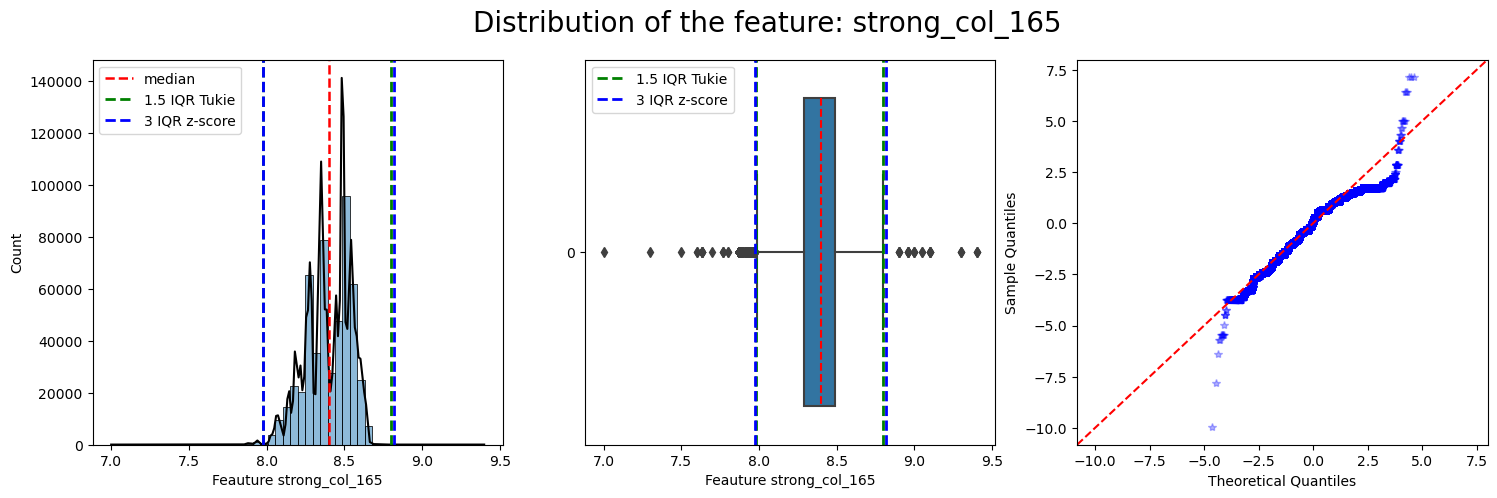

In [42]:
hist_box_qq(booking_df_2['strong_col_165'], full_iqr=True).show()

In [43]:
# Эта троица скидывает 0.0057
#year_of_review = pd.get_dummies(booking_df['year_of_review'].astype(str)).apply(lambda x: x.astype(int))
#quarter_of_review = pd.get_dummies(booking_df['quarter_of_review'].astype(str)).apply(lambda x: x.astype(int))
#hotel_town = pd.get_dummies(booking_df['hotel_town'].astype(str)).apply(lambda x: x.astype(int))

#booking_df_2 = pd.concat([booking_df_2, random_groupby], axis=1)

[to contents](#contents)


---
## Кое какой отбор <a id='sndblselection'></a>

Итак, посмотрим `f_classif`.

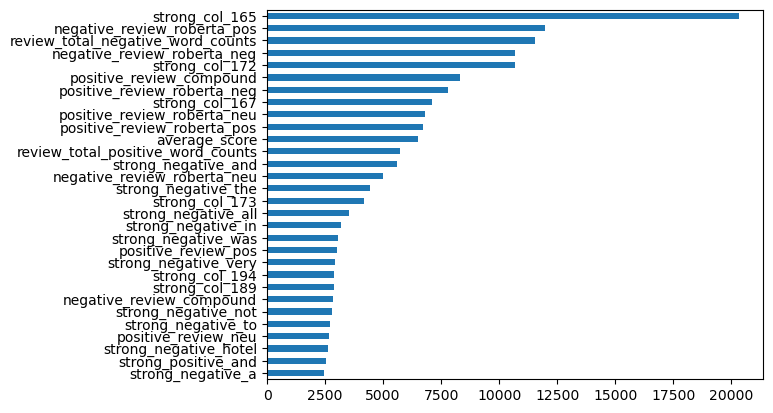

In [44]:
f_classif_chi_tester(booking_df_2.select_dtypes(include='number'), booking_df_2['reviewer_score']).loc[:, 'f_classif'].sort_values().tail(30).plot(kind='barh');

Прекрасная картина, я считаю.

Корреляция присутствует, но... ничего я дропать не буду. Ибо у нас тут происходит битва за мапе, а если я дропну - число мапе будет больше.  
Корреляцию беру от 0.7. Я не до конца помню градацию, но 0.7 вроде бы сильная корреляция.

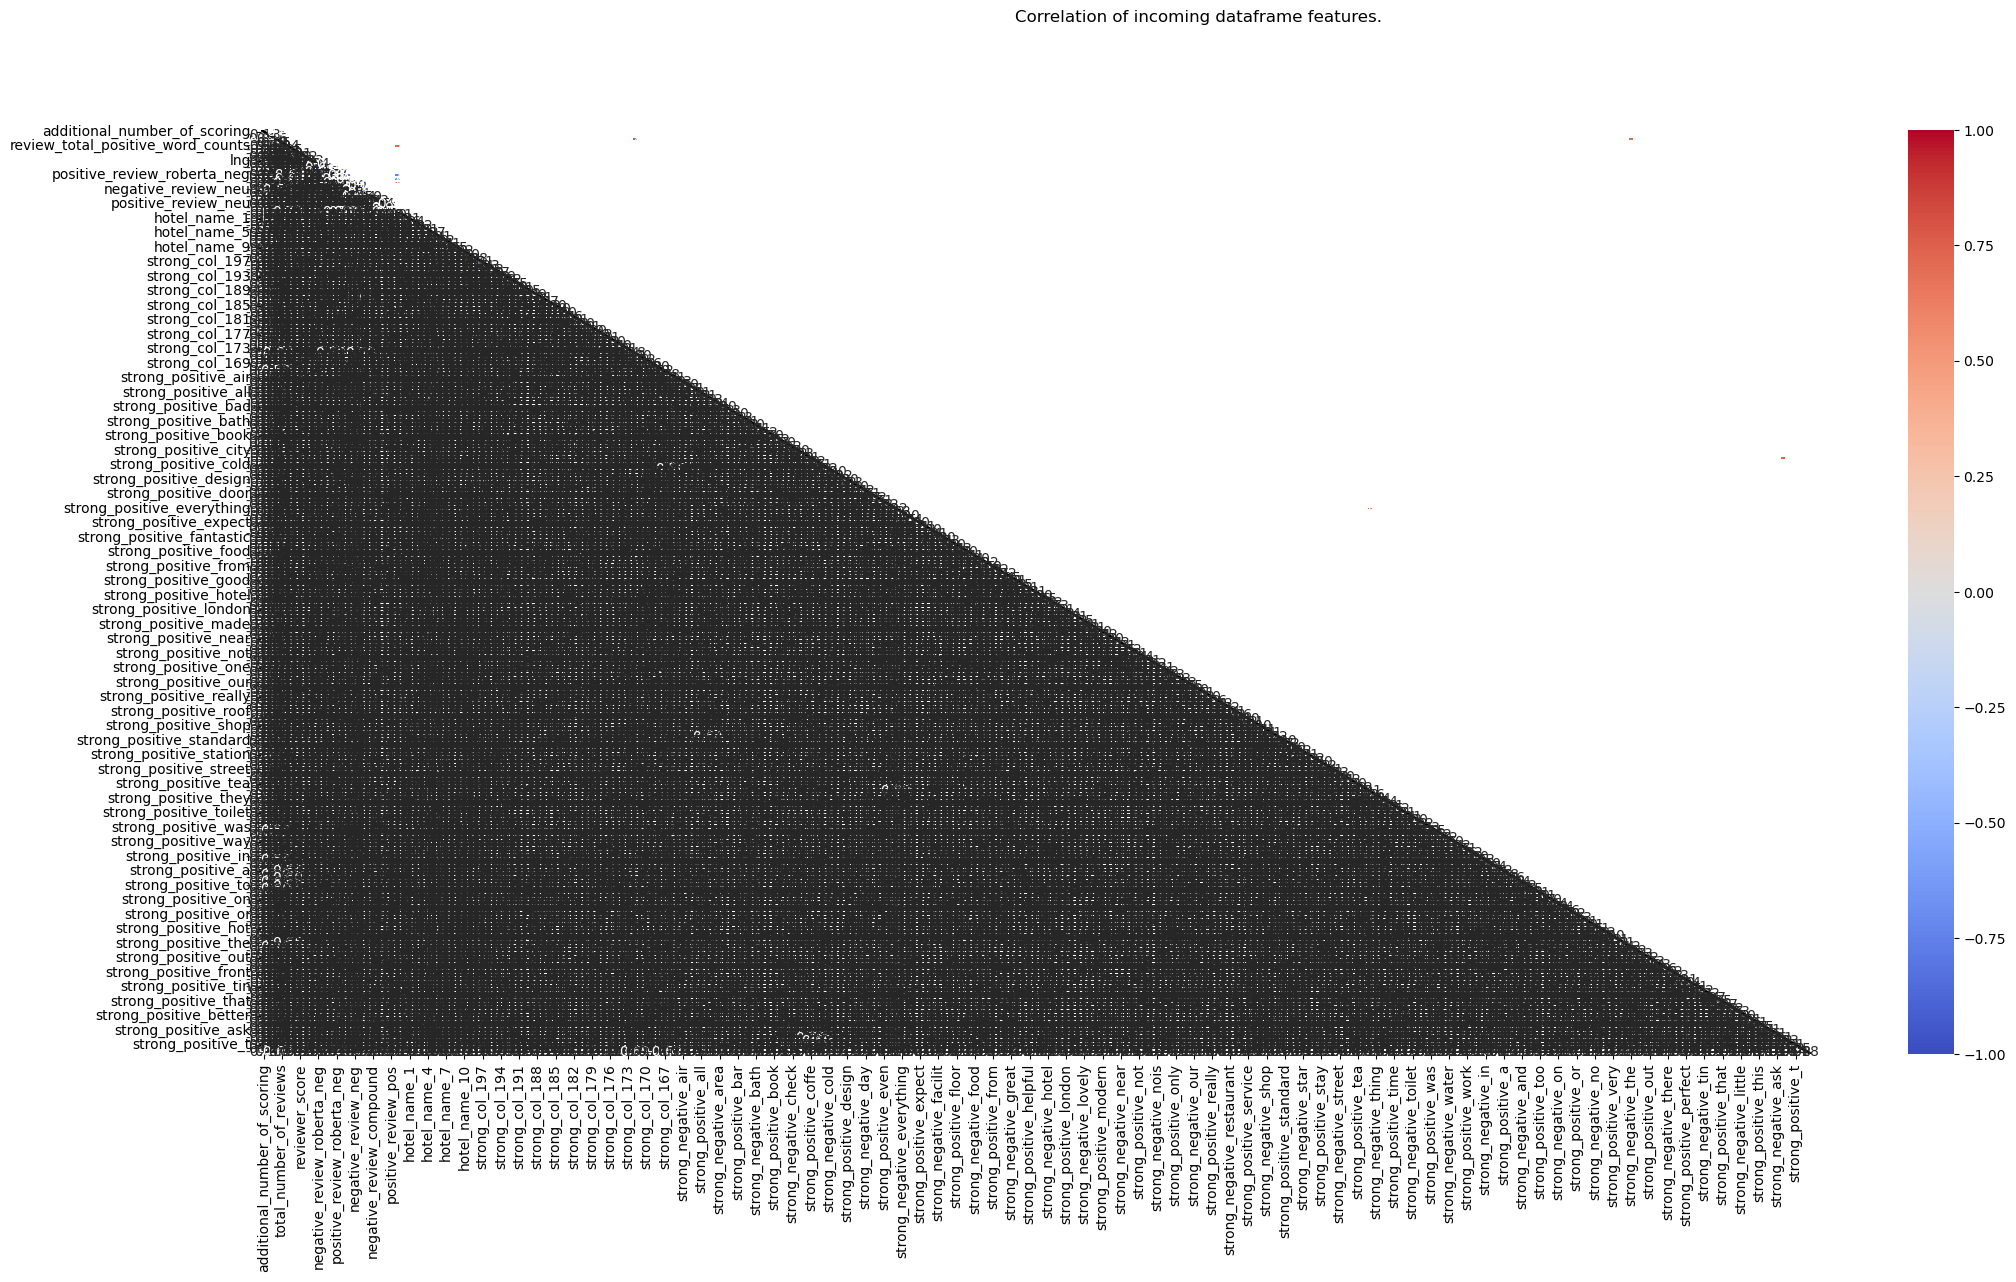

In [45]:
my_corr(booking_df_2, corrpos=0.7, corrneg=-0.7, figsize=(25,12)).show()

Что интересно, что сотня столбцов 0-1 вообще не коррелируют ни с чем. Волшебство.

Да и не густо так то корреляций.

In [46]:
my_corr(booking_df_2, corrpos=0.7, corrneg=-0.7, show_high_corr_cols_names=True)

,level_0,level_1,corr
0,additional_number_of_scoring,total_number_of_reviews,0.859014
1,positive_review_roberta_neg,positive_review_roberta_neu,0.858421
2,strong_positive_everything,strong_positive_thing,0.823939
3,positive_review_compound,positive_review_roberta_pos,0.822661
4,strong_positive_coffe,strong_positive_off,0.737245
5,positive_review_compound,review_total_positive_word_counts,0.725745
6,review_total_negative_word_counts,strong_negative_the,0.710178
7,positive_review_compound,positive_review_roberta_neg,-0.743453
8,negative_review_neg,negative_review_neu,-0.760129
9,review_total_negative_word_counts,strong_col_172,-0.800365


Согласен, `strong_positive_off` 0.73 коррелирует с `strong_positive_coffe`, как и `strong_negative_the` 0.71 с `review_total_negative_word_counts`, а так же `strong_positive_thing` с `strong_positive_everything` аж на 82.39% коррелируют, но.. пофигу. Если дропнуть - `мапе` станет больше. Про остальные вообще молчу. Там приличное такое ухудшение, если избавиться от корреляций.

Далее выделю `трэйн` часть и немного с ней пошаманю.  
Т.к., как я понял, самое главное, чтобы на тестовой выборке было нужное кол-во строк, а трейн я типа могу пилить как угодно. Т.к. на выходе получу обученную модель.. Которая.. я не представляю вообще, как выглядит.  
И мне её нужно применить на `тест`.  
А в `тесте` как раз и должно быть необходимое количество строк, которые нельзя трогать. А столбцы должны соответствовать.  
Не понятная мне система на самом деле. Ещё какой-то там файл `submission`, который, как я понял, просто должен быть.)

In [47]:
end_df_2 = booking_df_2.query('sample == "train"').drop_duplicates(ignore_index=True).select_dtypes(include='number')

In [48]:
# ценность этих 2х столбцов составляет 0.0042%. 
# Но на предсказании большинству моделей необходимо полное соответствие по столбцам. (хотя я проверил всего 2, а катбусту пофиг)
# Не хочу дропать из теста, потому закоммену эту строчку.

#end_df_2 = end_df_2.drop(columns=['lat', 'lng'])

Выбросы убираю методом Тьюки, который упакован в функцию из курса. Там.. аппер баунд, ловер баунд, вседела.) Удобно.  
Избавление от выбросов скидывает 0.1%. (писал до того, как почистил `positive_review_roberta_neg`)

In [49]:
#end_df_2 = outliers_iqr_mode_log(end_df_2, 'additional_number_of_scoring', left=1.45)[1]
#end_df_2 = outliers_iqr_mode_log(end_df_2, 'average_score')[1]
#end_df_2 = outliers_iqr_mode_log(end_df_2, 'total_number_of_reviews', left=1.45)[1]
#end_df_2 = outliers_iqr_mode_log(end_df_2, 'review_total_positive_word_counts')[1]
#end_df_2 = outliers_iqr_mode_log(end_df_2, 'total_number_of_reviews_reviewer_has_given')[1]
#end_df_2 = outliers_iqr_mode_log(end_df_2, 'positive_review_compound')[1]
#
#end_df_2 = outliers_iqr_mode_log(end_df_2, 'negative_review_roberta_neu')[1]
#end_df_2 = outliers_iqr_mode_log(end_df_2, 'positive_review_roberta_pos', left=1.9)[1]
#
## Избавление от выбросов в этом столбце скидывает аж целых 2%.
## Но, правда, там обрубилось 100 тыщ строк. Интересно, правильно ли это или нет.
#end_df_2 = outliers_iqr_mode_log(end_df_2, 'positive_review_roberta_neg', right=-0.3)[1]

(После того, как я дропнул выбросы из `positive_review_roberta_neg`, число `mape` стало 8% на катбусте, я испугался и решил больше ничего не трогать. Т.к. у всех 11, 12. Я скорее всего что-то не правильно делаю.

В некоторых столбцах у меня не получилось убрать выбросы. Они не убираются, как бы я границы не двигал.  
Столбец `positive_review_neg` вообще отбитый, ни логарифмирование не помогает, ни выбросы не убираются, оно там всё отбросами считает.)

Здесь я объясню, почему я закомментил отлов выбросов.

После того, как я отправил свой первый сабмишн и увидел 12.38, я подумал: "в чём может быть проблема?". Сначала попробовал убрать исправление > 10 и < 2.5, об этом ниже, но не помогло. Я подумал, что проблема в моих "добавках", когда я там списки формировал и менял слова на neutral. Но тоже нет. А потом закомментил отлов выбросов и всё встало на свои места. Выбросы, видимо, очень щепетильная тема, которую я пока не понимаю. 

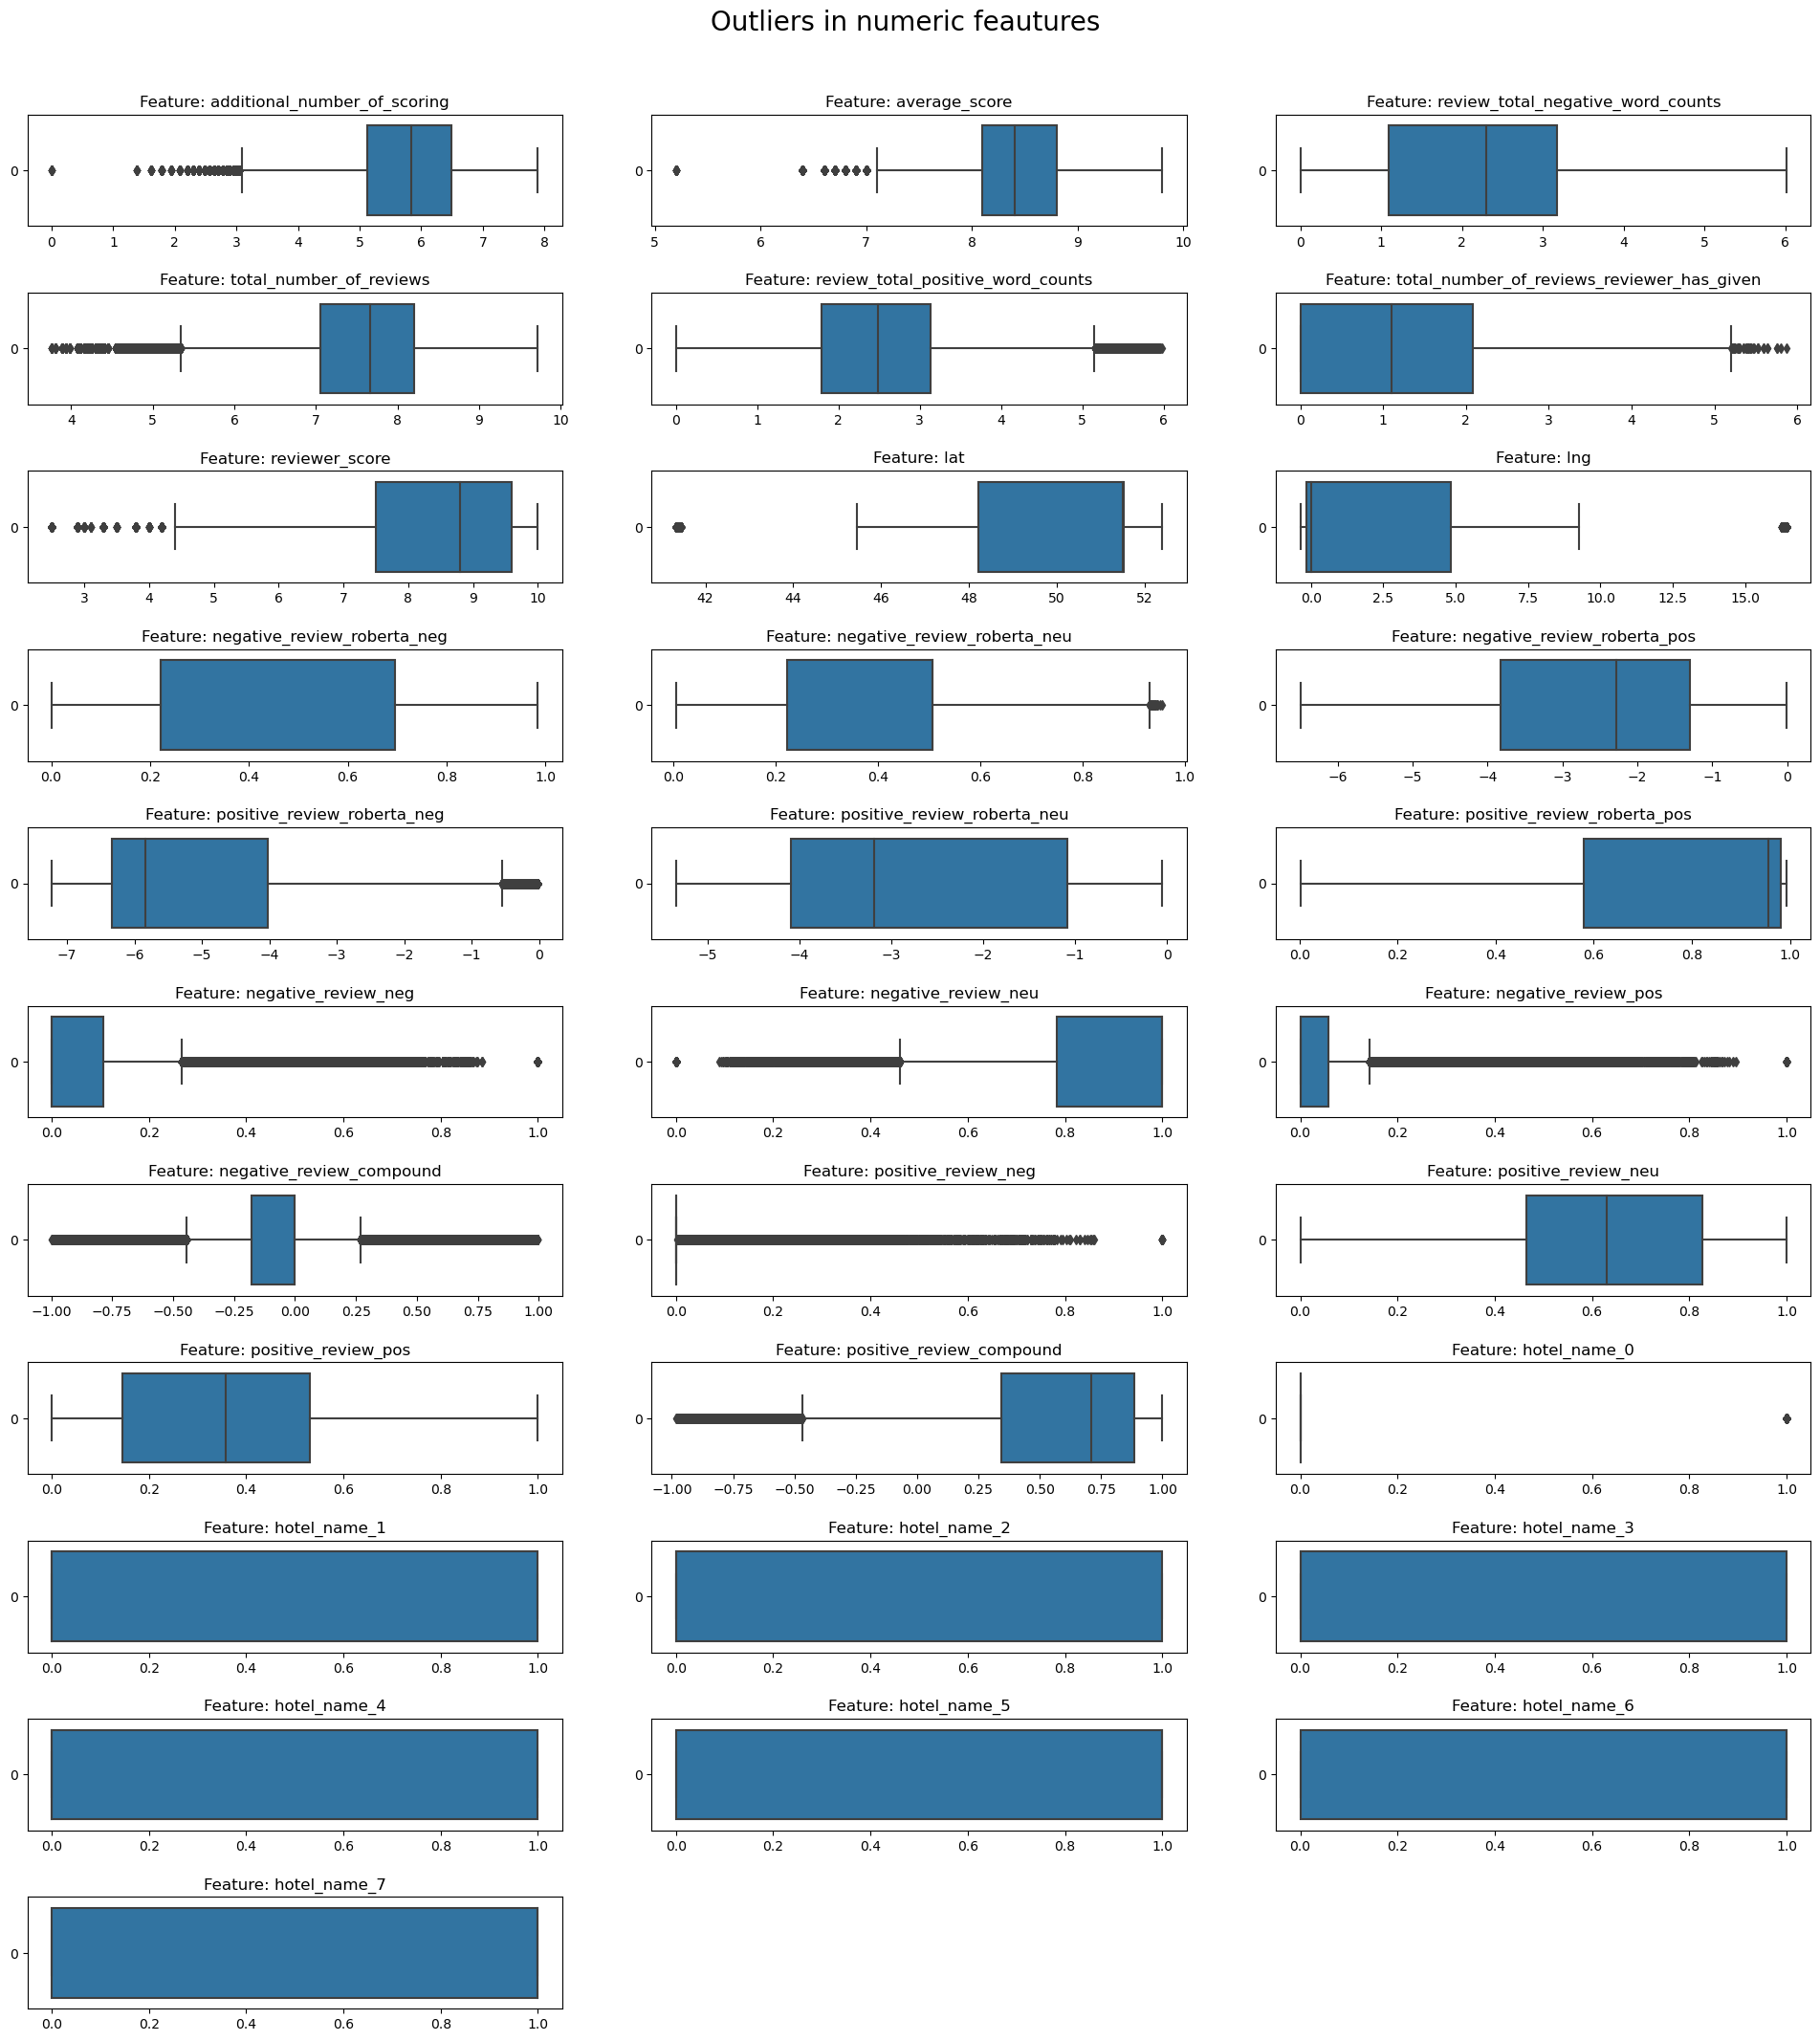

In [50]:
# Я рубану бинарники.
df_for_this_cell = end_df_2.iloc[:, :len(end_df_2.columns)//8]

nrows = (df_for_this_cell.shape[1] + 2) // 3 
fig, ax = plt.subplots(ncols=3, nrows=nrows, figsize=(20, 22))

plt.suptitle('Outliers in numeric feautures', fontsize=20)

fig.tight_layout(pad=3) # расстояние между подграфиками
plt.subplots_adjust(top=0.93) # чтобы заголовок не налезал на графики

# На каждой итерации рисуется график в определённую ячейку: 0-0, 0-1, 0-2, 1-0 и т.д.
for idx, feature in enumerate(df_for_this_cell.columns):
    row = idx // 3
    col = idx % 3
    
    sns.boxplot(data=df_for_this_cell[feature], ax=ax[row, col], orient='h')
    ax[row, col].set_title(f'Feature: {feature}')
    
# Удаляем пустые subplot'ы
for i in range(len(df_for_this_cell.columns), nrows*3):
    row = i // 3
    col = i % 3
    fig.delaxes(ax[row, col])

plt.show()

In [51]:
# Удалю этот отбитый столбец. Скидывает 0.02%.
# Тут внимание! Удаляю из обоих дф-ников:
# и из основного и из тренировочного.
# Т.к. катбусту пофиг, а лес - ругается.
end_df_2 = end_df_2.drop(columns=['positive_review_neg'])
booking_df_2 = booking_df_2.drop(columns=['positive_review_neg'])

[to contents](#contents)


---
## И тренировка второго блока <a id='sndbltraining'></a>

Здесь я уже возьму поболе алгоритмов, т.к. блок 2 - итоговый. 

In [52]:
# list of names algs

list_of_ml_algs = ['RandomForestRegressor', 'CatBoostRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'AdaBoostRegressor', 'DecisionTreeRegressor']
#list_of_ml_algs = ['RandomForestRegressor', 'CatBoostRegressor', 'ExtraTreesRegressor']

# params for each alg порядок не важен.
# Сорямба, здесь гитхаб весия, потому у леса 10 эстиматоров.
params_dict = {
        'RandomForestRegressor': [{'n_estimators': 10, 'n_jobs': -1, 'random_state': 42}, {}],
        'ExtraTreesRegressor': [{'n_estimators': 10, 'max_depth': 3}, {}],
        'GradientBoostingRegressor': [{'n_estimators': 10, 'learning_rate': .1}, {}],
        'CatBoostRegressor': [{'iterations': 12000, 'learning_rate': .1, 'depth': 3, 'verbose': False}, {}],
        'AdaBoostRegressor': [{'n_estimators': 10, 'learning_rate': 1.0}, {}]
}

# magic func
models_df_2 = multiple_models_training(end_df_2, 'reviewer_score', list_of_ml_algs=list_of_ml_algs, params_dict=params_dict, test_size=0.25)

КОРОЛЬ АРТУР НА НАС НАПАЛИ!!!


Cell progress: : 0%|          | 0/100 [Elapsed: 00:00 m/s]

Model training completed! With: 28.57 sec. Alg: RandomForestRegressor.
Model training completed! With: 2.25 min. Alg: CatBoostRegressor.
Model training completed! With: 7.12 sec. Alg: ExtraTreesRegressor.
Model training completed! With: 16.73 sec. Alg: GradientBoostingRegressor.
Model training completed! With: 30.19 sec. Alg: AdaBoostRegressor.
Model training completed! With: 14.67 sec. Alg: DecisionTreeRegressor.
Mission accomplished.


Без лишних комментариев.)

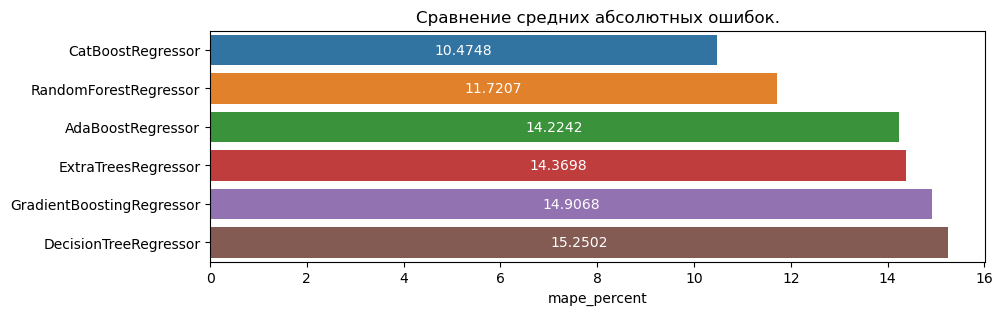

In [55]:
fig, ax = plt.subplots(figsize=(10, 3))

sns.barplot(models_df_2, x='mape_percent', y='alg_name')

ax.set_title(f'Сравнение средних абсолютных ошибок.')
ax.bar_label(ax.containers[0], fmt='%.4f', label_type='center', color='white')
ax.set_ylabel('');

Катбуст:

11.4476 - если добавить в изначальный дф-ник только работу алгоритмов вейдера и роберты, (добавить бинарное кодирование названий отелей и выцепить 4 слова из тегов == 0.01%).  

11.3687 - |  
11.2588 - | эти 2, если ещё допилить отлов выбросов, где это возможно (на мой взгляд) и логарифмирование логнормальных распределений. 
 
11.0743 - если добавить бинарные столбцы: локация, стаф, завтрак, кровать, окно.  
11.0004 - -||- паркинг, вид, чистота, курение, вайфай, цена.  
10.9834 - если добавить отдельным столбцов нонегатив и нопозитив (в моём случае neutral).  
10.8607 - если добавить exspensive, room, old.  

Я там ещё шаманил. С этого всё начиналось.)

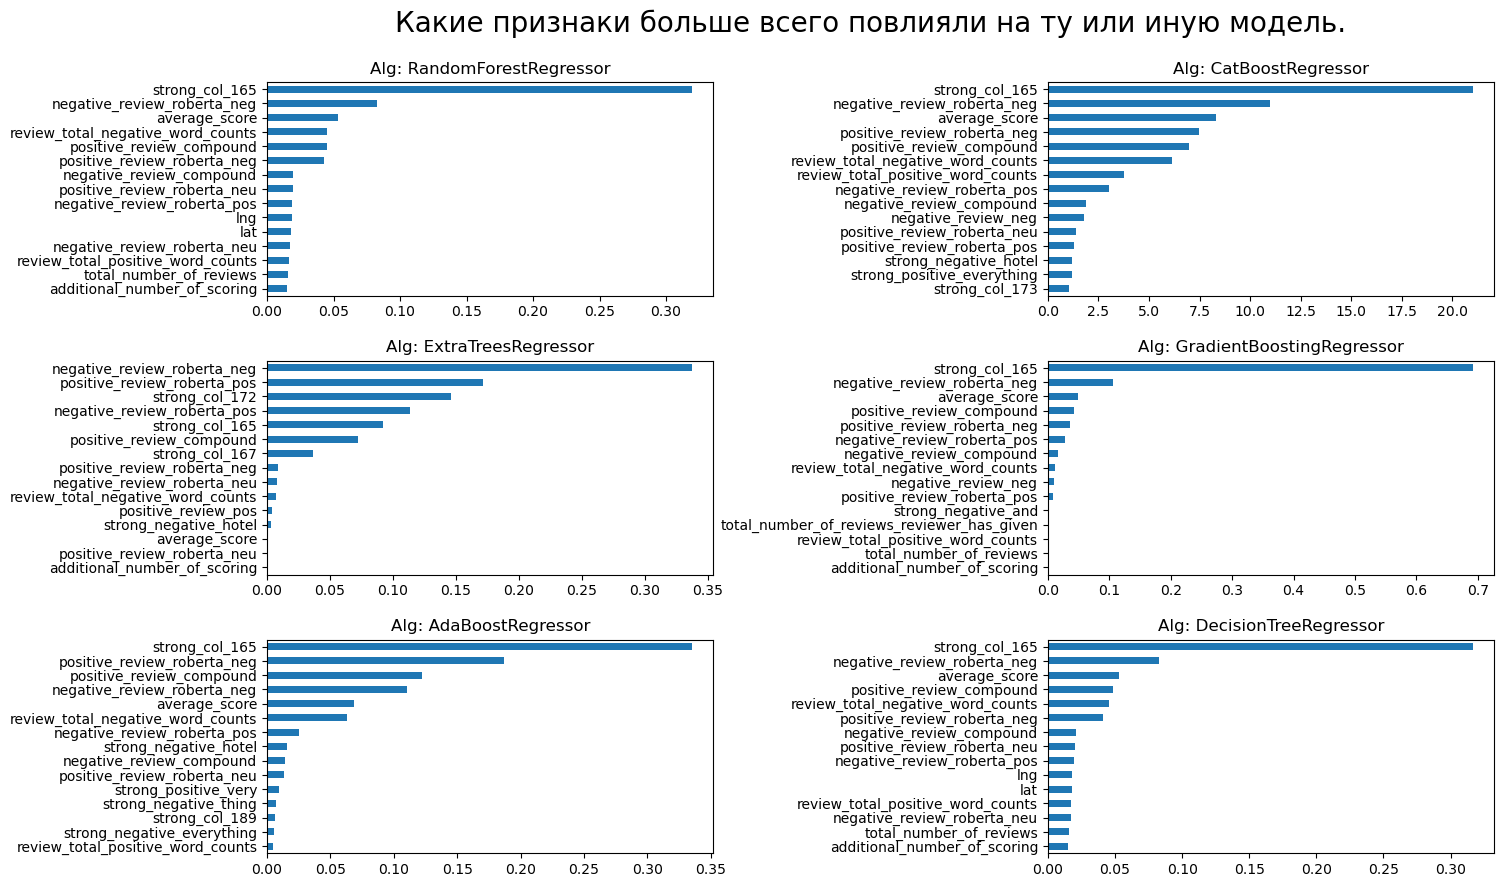

In [56]:
nrows = len(list_of_ml_algs) // 2 if len(list_of_ml_algs) % 2 == 0 else len(list_of_ml_algs) // 2 + 1
fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(13, 9))

row = 0
col = 0

fig.tight_layout(w_pad=21, h_pad=3) # расстояние между подграфиками
plt.subplots_adjust(top=0.9) # чтобы заголовок не налезал на графики

plt.suptitle('Какие признаки больше всего повлияли на ту или иную модель.').set_fontsize(20)

for idx, feature in enumerate(list_of_ml_algs):
    row = idx // 2
    col = idx % 2
    
    feat_importances = pd.Series(models_df_2.loc[models_df_2['alg_name'] == feature, 'model'].iloc[0].feature_importances_, index=end_df_2.drop(columns=['reviewer_score']).columns)
    
    feat_importances.nlargest(15).sort_values().plot(kind='barh', ax=ax[row, col]);
    
    ax[row, col].set_title(f'Alg: {feature}')
    
# Удаляем пустые subplot'ы
for i in range(len(list_of_ml_algs), nrows*2):
    row = i // 2
    col = i % 2
    fig.delaxes(ax[row, col])

plt.show()

Ну и сказочке конец.))  
Такие дела, брат... Любовь.)

[to contents](#contents)


---
# Здесь находится итоговая модель <a id='modellocation'></a>

Надеюсь, я всё правильно делаю.)

In [57]:
models_df_2

,alg_name,mape_percent,accuracy,model
0,CatBoostRegressor,10.474830,0.623384,<catboost.core.CatBoostRegressor object at 0x2...
1,RandomForestRegressor,11.720688,0.534929,"(DecisionTreeRegressor(max_features=1.0, rando..."
2,AdaBoostRegressor,14.224176,0.378085,"(DecisionTreeRegressor(max_depth=3, random_sta..."
3,ExtraTreesRegressor,14.369794,0.387836,"(ExtraTreeRegressor(max_depth=3, random_state=..."
4,GradientBoostingRegressor,14.906823,0.381229,([DecisionTreeRegressor(criterion='friedman_ms...
5,DecisionTreeRegressor,15.250158,0.123333,DecisionTreeRegressor()


In [58]:
model = models_df_2.loc[models_df_2['alg_name'] == 'CatBoostRegressor', 'model'].iloc[0]

# Забираю тест дату из общей солянки второго блока.
test_data = booking_df_2.query('sample == "test"').drop(['reviewer_score'], axis=1).reset_index(drop=True).select_dtypes(include='number')

predict_submission = model.predict(test_data)

# Пардон, я подсмотрел, что там типа макс оценка = 10, а мин типа 2.5, хотя я бы 0.5 оставил. 
# А что, вдруг совсем отвратный отель.) Но, сделаю, как у всех, вдруг так надо.
predict_submission = round(pd.Series(predict_submission).apply(lambda x: 10 if x > 10 else 2.5 if x < 2.5 else x), 1)

predict_submission

# Отмечу, что изменение на 10 и 2.5, и округление - скидывает 0,005%, но оставлю закомменченым.
# Так же отмечу, что здесь я использую рандомфорест, 
# а потом, дополнительно, сделал катбуст и вкинул сабмишн катбуста. 
# Оказывается можно любым алгоритмом делать сабмишн.

0        8.500000
1        8.200000
2        9.000000
3        9.900000
4        9.700000
           ...   
128930   8.600000
128931   9.300000
128932   8.600000
128933   9.600000
128934   6.500000
Length: 128935, dtype: float64

[to contents](#contents)